In [565]:
import numpy as np 
import pandas as pd
from sklearn import *
from sklearn.metrics import f1_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import time
import xgboost as xgb
from catboost import Pool,CatBoostRegressor
import datetime
import gc
import os
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import preprocessing, metrics
import gc
import joblib
import warnings

sns.set()



sns.set_style("whitegrid")



In [566]:
path = '/home/dohee/kaggle/nims/input'
os.chdir(path)
os.listdir()

['test.csv',
 'sample_submission.csv',
 'train.csv',
 '“NIMS 풀림” 답안 제출동의서.pdf',
 'lgbm_0.sav']

In [567]:
#1만 세대의 2009-01부터 2018-05까지 사용량으로부터 2018-06부터 2019-05까지 12개월 도시가스 사용량을 예측하는 문제

In [568]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
all_cols = list(train.columns)[1:]

In [569]:
train

,id,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05
0,0,26.68,11.86,19.77,14.83,7.90,2.96,5.93,4.94,4.94,4.94,6.92,19.77,31.63,19.77,23.72,13.83,11.86,11.86,5.93,4.94,3.95,5.93,5.93,17.79,14.82,35.58,26.68,16.80,9.88,5.93,4.94,1.97,4.94,6.91,6.91,17.79,25.70,32.62,18.78,21.75,9.88,6.92,4.94,3.95,5.93,6.92,5.93,3.95,0.00,25.70,33.63,14.83,7.91,7.91,6.92,6.92,3.95,3.95,5.93,15.82,32.64,38.58,29.67,16.81,10.88,3.95,4.94,4.94,4.94,5.93,14.83,19.78,23.74,25.71,33.63,11.87,8.90,3.95,3.95,6.92,2.96,5.93,8.90,12.86,26.71,35.61,31.62,11.86,6.91,3.95,2.96,1.97,2.96,1.97,6.91,10.87,5.93,3.95,3.95,5.92,4.94,4.94,4.94,0.00,0.98,2.96,6.91,7.90,6.91,0.00,8.89,9.88,7.90,3.95,0.98,1.97,0.98,2.96,4.94,6.91,9.88,0.00,2.96,7.90,4.94
1,1,107.73,77.09,79.09,4.94,48.44,22.74,33.61,23.72,23.72,25.70,48.44,86.01,117.65,77.11,39.53,46.45,48.43,22.73,17.79,23.72,23.72,52.38,14.82,41.51,123.55,134.42,84.02,40.52,24.71,23.72,15.81,12.85,12.85,15.81,17.79,21.74,58.32,76.11,39.55,30.65,33.61,18.78,17.79,6.92,12.85,17.79,20.76,43.50,78.11,73.17,26.71,22.75,26.71,18.79,13.85,6.92,6.92,13.85,10.88,87.05,58.36,80.13,51.43,26.70,19.78,17.80,10.88,8.90,4.94,14.83,11.87,18.79,31.65,22.75,39.57,20.77,19.78,14.83,11.87,7.91,6.92,8.90,10.88,19.78,44.51,62.32,47.44,30.64,20.75,19.76,6.91,6.91,8.89,14.82,21.74,40.52,41.51,88.95,79.04,39.52,29.64,16.79,16.79,11.85,8.89,19.76,19.76,54.34,113.63,118.57,88.94,54.35,37.55,26.68,20.75,11.85,11.85,19.76,22.73,38.54,145.28,56.33,62.26,58.31,32.61
2,2,94.88,90.93,78.10,66.24,38.55,25.70,27.68,26.69,18.78,15.81,45.48,67.23,70.19,49.43,36.57,29.65,32.61,13.83,17.79,12.84,11.86,18.77,66.22,98.84,179.88,213.49,98.85,85.99,89.95,44.48,28.66,35.58,25.70,61.28,76.11,136.41,242.18,257.01,169.08,154.25,62.29,35.59,28.67,20.76,13.84,37.57,76.13,112.72,258.07,174.02,138.50,131.57,70.24,11.87,31.65,19.78,10.88,24.73,64.30,112.78,159.27,190.93,187.94,126.61,92.98,0.00,0.00,0.00,0.00,0.00,127.60,3.95,137.49,19.78,66.28,49.46,49.46,9.89,1.97,11.87,4.94,0.00,47.48,47.48,78.15,64.30,68.19,49.42,36.57,13.83,1.97,6.91,0.00,19.76,26.68,28.66,27.67,58.31,57.30,30.63,25.69,13.83,13.83,5.92,9.88,13.83,26.67,71.14,175.88,137.34,88.94,233.23,92.90,13.83,0.00,0.00,0.00,0.00,0.00,81.04,130.45,71.15,0.00,0.00,0.00
3,3,0.00,0.00,149.29,51.41,6.92,8.89,2.96,2.96,1.97,3.95,4.94,5.93,20.76,21.75,20.75,9.88,4.94,1.97,2.96,2.96,0.98,3.95,3.95,3.95,9.88,4.94,8.89,3.95,3.95,2.96,1.97,1.97,1.97,1.97,2.96,2.96,16.80,11.86,5.93,5.93,3.95,5.93,4.94,5.93,6.92,15.82,19.77,51.41,88.00,110.74,67.27,65.29,30.66,23.74,20.77,14.83,7.91,10.88,13.85,61.33,74.19,64.30,78.14,57.37,50.44,41.54,26.70,19.78,13.84,0.00,0.00,0.00,0.00,156.29,64.30,52.43,63.31,9.89,0.00,14.83,2.96,7.91,23.74,82.11,79.14,122.67,103.78,98.84,13.83,9.88,8.89,5.93,2.96,8.89,20.75,18.77,25.69,119.59,95.84,75.09,25.69,13.83,17.78,7.90,9.88,16.79,61.26,119.56,195.64,220.34,199.63,145.28,55.34,38.54,0.00,0.00,0.00,5.92,26.68,74.12,158.12,159.11,105.75,86.97,43.48
4,4,97.85,97.85,70.19,60.31,31.63,25.70,20.76,22.74,20.76,20.76,34.60,76.12,125.56,103.81,85.00,67.21,75.11,25.69

In [570]:
# import copy
# tmp = copy.copy(train.iloc[:, 78-12:-12])
# tmp.columns  = train.columns[78:]
# tmp

In [571]:
# 최근 3년 선택하기
train = train.iloc[:,78:]
test = test.iloc[:,78:]

In [572]:
# 너무 큰 값 처리

# Maximum value list
max_list = test.max()
max_list

test_max = test.max()

margin = 10

test_max['2018-06'] = test_max['2017-06'] + margin
test_max['2018-07'] = test_max['2017-07'] + margin
test_max['2018-08'] = test_max['2017-08'] + margin
test_max['2018-09'] = test_max['2017-09'] + margin
test_max['2018-10'] = test_max['2017-10'] + margin
test_max['2018-11'] = test_max['2017-11'] + margin
test_max['2018-12'] = test_max['2017-12'] + margin
test_max['2019-01'] = test_max['2018-01'] + margin
test_max['2019-02'] = test_max['2018-02'] + margin
test_max['2019-03'] = test_max['2018-03'] + margin
test_max['2019-04'] = test_max['2018-04'] + margin
test_max['2019-05'] = test_max['2018-05'] + margin

print("before:", train.shape[0])

for i in train:
    maximum = test_max[i]
    # 최대값보다 큰 값을 없애기
    train = train[train[i]<=maximum]

print("after:", train.shape[0])
    
# for i in tmp:
#     maximum = test_max[i]
#     # 최대값보다 큰 값을 없애기
#     tmp = tmp[tmp[i]<=maximum]
    
train = train.reset_index(drop=True)
# tmp = tmp.reset_index(drop=True)

before: 78587
after: 65785


In [573]:
# from sklearn.preprocessing import StandardScaler
# train[list(test.columns)] = StandardScaler().fit_transform(train[list(test.columns)])
# # tmp[list(test.columns)] = StandardScaler().fit_transform(tmp[list(test.columns)])
# test[list(test.columns)] = StandardScaler().fit_transform(test[list(test.columns)])

In [574]:
# 2배로 만들기
# train = pd.concat([train, tmp], axis=0).reset_index(drop=True)

### 최근 3년간 2009년 1월 ~ 2019년 5월

In [575]:
jan = train.columns[[i*12-5 for i in range(1, 5)]]
feb = train.columns[[i*12-4 for i in range(1, 5)]]
mar = train.columns[[i*12-3 for i in range(1, 5)]]
apr = train.columns[[i*12-2 for i in range(1, 5)]]
may = train.columns[[i*12-1 for i in range(1, 5)]]
jun = train.columns[[i*12 for i in range(4)]]
jul = train.columns[[1+i*12 for i in range(4)]]
aug = train.columns[[2+i*12 for i in range(4)]]
sep = train.columns[[3+i*12 for i in range(4)]]
occ = train.columns[[4+i*12 for i in range(4)]]
nov = train.columns[[5+i*12 for i in range(4)]]
dec = train.columns[[i*12-6 for i in range(1, 5)]]

df_jun = train[jun].copy()
df_jul = train[jul].copy()
df_aug = train[aug].copy()
df_sep = train[sep].copy()
df_occ = train[occ].copy()
df_nov = train[nov].copy()
df_dec = train[dec].copy()
df_jan = train[jan].copy()
df_feb = train[feb].copy()
df_mar = train[mar].copy()
df_apr = train[apr].copy()
df_may = train[may].copy()

In [576]:
# # 상위 2% 이하인 것들은 2%에 해당하는 값으로 제한하기
# for i in df_jun:
#     up = np.quantile(df_jun[i], [0.98])[0]
#     df_jun[i][df_jun[i]>up]=up

In [577]:
df_jun.mean()

2015-06    18.203221
2016-06    18.037391
2017-06    16.819121
2018-06    19.417603
dtype: float64

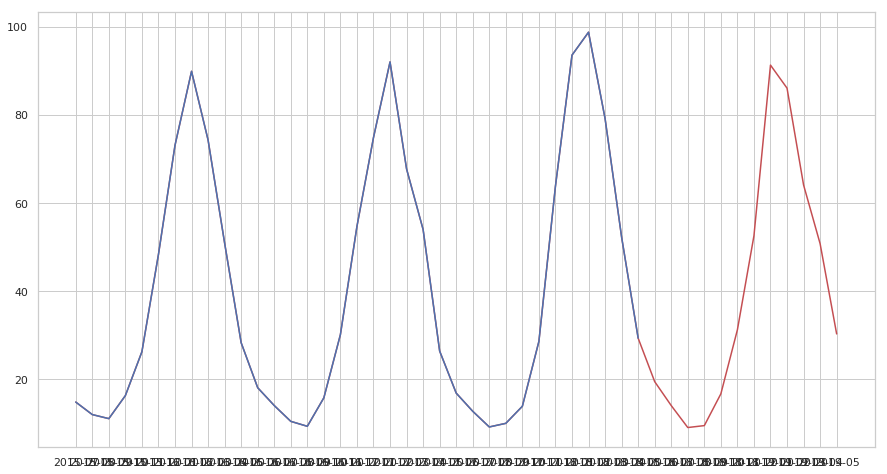

In [578]:
plt.figure(figsize=(15,8))
plt.plot(train.iloc[:,1:].mean(), c='r')
plt.plot(train.iloc[:,1:-12].mean(), c='b')

In [579]:
df_jun.values

array([[ 3.95,  3.95,  4.94,  3.95],
       [14.83, 19.76, 16.79, 26.68],
       [ 9.89, 13.83, 13.83, 13.83],
       ...,
       [ 4.94,  4.94,  5.92,  4.94],
       [28.68, 26.68, 27.66, 11.85],
       [37.59, 27.67, 28.65, 29.64]])

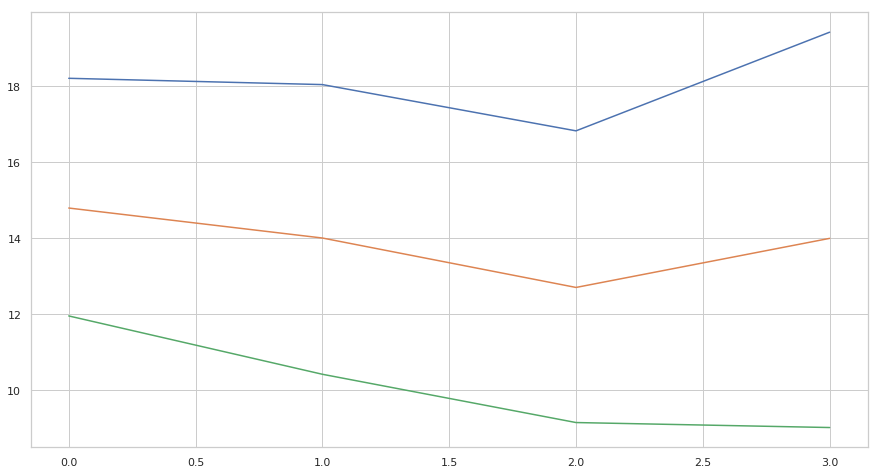

In [580]:
plt.figure(figsize=(15,8))
plt.plot(df_jun.values.mean(axis=0))
plt.plot(df_jul.values.mean(axis=0))
plt.plot(df_aug.values.mean(axis=0))

In [581]:
df_jun.mean()

2015-06    18.203221
2016-06    18.037391
2017-06    16.819121
2018-06    19.417603
dtype: float64

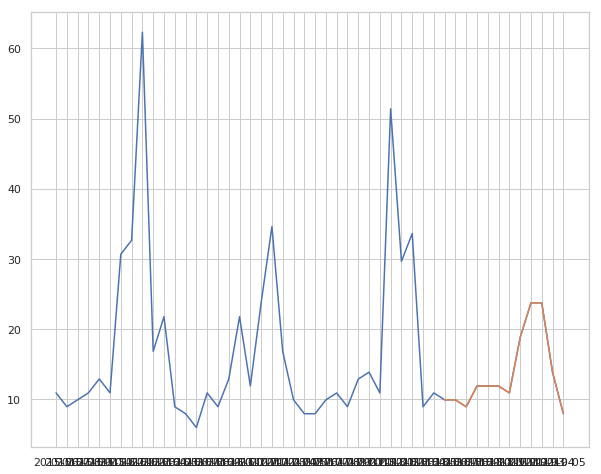

In [582]:
row = 289
plt.figure(figsize=(10,8))
plt.plot(train.iloc[row,:])
plt.plot(train.iloc[row,-12:])
plt.show()

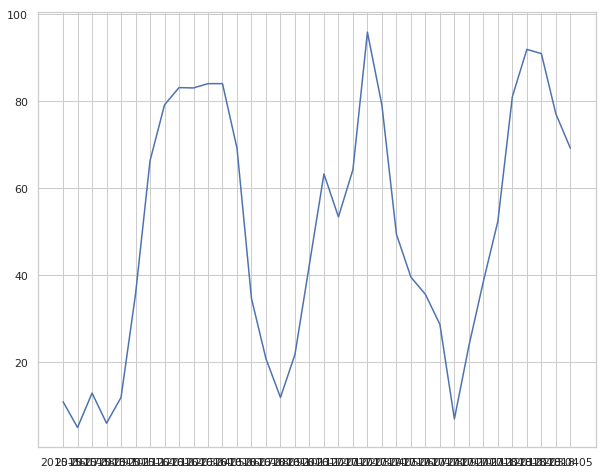

In [583]:
row = 12
plt.figure(figsize=(10,8))
plt.plot(test.iloc[row,:])
plt.show()

지지지난해 같은 달의 값 <br/>
지지난해 같은 달의 값 <br/>
지난해 같은 달의 값 <br/>
지난해 근방(3,5,7개월)의 평균 <br/>
지지난해 근방(3개월)의 평균
지지지난해 근방(3개월)의 평균

최근 3년의 평균 <br/>
지난해의 분산 <br/>
지지난해의 분산 <br/>
지지지난해의 분산 <br/>
지난해 0의 count <br/>

In [584]:
# 사용량이 있다가 계량기 고장으로 0으로 떨어지는 경우
# 거주지 이전으로 인해 사용량이 0인 경우
# 고객이 사용량을 전화나 문자로 알려줄 때 사용량을 속여 매월 일정한 값을 제공하는 경우
# 도시가스 용도가 잘못 기재되어 월별 사용량이 비정상적으로 큰 경우

In [585]:
#def f1_score_calc(y_true, y_pred):
#    return f1_score(y_true, y_pred, average="macro")

from sklearn.metrics import mean_squared_error
folds = KFold(n_splits=5, shuffle=True, random_state=123)


def train_model_classification(X, X_test, y, params, model_type='lgb', eval_metric='rmse',
                               columns=None, plot_feature_importance=True, model=None,
                               verbose=200, early_stopping_rounds=200, n_estimators=2000):

    columns = [col for col in list(X.columns) if col!='target'] # if columns == None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    #metrics_dict = {
    #                'f1score': {'lgb_metric_name': lgb_Metric,}
    #               }
    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X) )
    
    # averaged predictions on train data
    prediction = np.zeros((len(X_test)))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        #if True:        
        #    X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=7)    

        if model_type == 'lgb':

            model = lgb.LGBMRegressor(**params)
            model.fit(X_train, y_train,
                    eval_set=[(X_valid, y_valid)],
                    eval_metric='rmse',
                    early_stopping_rounds=early_stopping_rounds)

            #model = lgb.train(params, lgb.Dataset(X_train, y_train),
            #                  n_estimators,  lgb.Dataset(X_valid, y_valid),
            #                  verbose_eval=verbose, early_stopping_rounds=early_stopping_rounds)

            preds = model.predict(X_valid, num_iteration=model.best_iteration_) #model.predict(X_valid) 
            y_pred_valid = preds
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            y_pred = y_pred


        if model_type == 'xgb':
            train_set = xgb.DMatrix(X_train, y_train)
            val_set = xgb.DMatrix(X_valid, y_valid)
            model = xgb.train(params, train_set, num_boost_round=2222, evals=[(train_set, 'train'), (val_set, 'val')], 
                                     verbose_eval=verbose, early_stopping_rounds=early_stopping_rounds)

            preds = model.predict(xgb.DMatrix(X_valid)) #model.predict(X_valid) 
            y_pred_valid = preds#np.round(np.clip(preds, 0, 10)).astype(int)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            y_pred = y_pred#np.round(np.clip(y_pred, 0, 10)).astype(int)


#             preds = model.predict(xgb.DMatrix(X)) 
#             y_pred = model.predict(xgb.DMatrix(X_test))


        if model_type == 'cat':
            # Initialize CatBoostRegressor
            model = CatBoostRegressor(params)
            # Fit model
            model.fit(X_train, y_train)
            # Get predictions
            y_pred_valid = preds#np.round(np.clip(preds, 0, 10)).astype(int)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            y_pred = y_pred#np.round(np.clip(y_pred, 0, 10)).astype(int)


        oof = preds

        scores.append(mean_squared_error(y_valid, y_pred_valid )**0.5 )
        prediction += y_pred    

        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('FINAL score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    result_dict['model'] = model
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

In [586]:
#Let's uses 'singal_undrifted' instead of 'signal'
#cols_to_remove = []

TRAINING = True
MODEL_TYPE = 'lgb'

if TRAINING and MODEL_TYPE == 'lgb':
    params = {'learning_rate': 0.1, 
              'max_depth': 7, 
              'num_leaves':2**5+1, 
              'num_iterations':400,
              'metric': 'rmse', 
              'random_state': 7, 
              'reg_lambda': 0.5,
              'n_jobs':-1,
              'verbose':-1}
    
    
    
#     params = {'num_leaves': 4,
#       'min_data_in_leaf': 5,
#       'objective':'fair',
#       'max_depth': -1,
#       'learning_rate': 0.02,
#       "boosting": "gbdt",
#       'boost_from_average': True,
#       "feature_fraction": 0.9,
#       "bagging_freq": 1,
#       "bagging_fraction": 0.5,
#       "bagging_seed": 0,
#       "metric": 'mae',
#       "verbosity": -1,
#       'max_bin': 500,
#       'reg_alpha': 0,
#       'reg_lambda': 0,
#       'seed': 0,
#       'n_jobs': 1
#       }

#     params = {
#         'boosting_type': 'gbdt',
#         'objective': 'poisson',
#         'metric': 'rmse',
#         'learning_rate': 0.01,
#         'num_leaves':255,
#         'max_depth': 8,  
#         'min_child_samples': 100,  
#         'max_bin': 100,  
#         'subsample': 0.7,  
#         'subsample_freq': 1,  
#         'colsample_bytree': 0.7,  
#         'min_child_weight': 0,  
#         'subsample_for_bin': 200000,  
#         'min_split_gain': 0,  
#         'reg_alpha': 0,  
#         'reg_lambda': 0,  
#        # 'nthread': 8,
#         'verbose': 200,
#         'scale_pos_weight':99 

In [587]:
# windows = [3,5]

# #windows = [3,5,7,9,11]


# rolling_mean_dict = {}
# rolling_std_dict = {}
# rolling_var_dict = {}
# rolling_min_dict = {}
# rolling_max_dict = {}
# rolling_ratio_dict = {}
# rolling_diff_dict = {}

# # rolling_mean_dict2 = {}
# # rolling_std_dict2 = {}
# # rolling_var_dict2 = {}
# # rolling_min_dict2 = {}
# # rolling_max_dict2 = {}
# # rolling_ratio_dict2 = {}
# # rolling_diff_dict2 = {}

# for window in windows:
#     rolling_mean = train.rolling(window=window, min_periods=1, axis=1, center=True).median()
#     rolling_std = train.rolling(window=window, min_periods=1, axis=1, center=True).std()
#     rolling_var = train.rolling(window=window, min_periods=1, axis=1, center=True).var()
#     rolling_min = train.rolling(window=window, min_periods=1, axis=1, center=True).min()
#     rolling_max = train.rolling(window=window, min_periods=1, axis=1, center=True).max()
#     rolling_ratio = rolling_min / rolling_max
#     rolling_diff = rolling_max - rolling_min

#     rolling_mean_dict[window] = rolling_mean
#     rolling_std_dict[window] = rolling_std
#     rolling_var_dict[window] = rolling_var
#     rolling_min_dict[window] = rolling_min
#     rolling_max_dict[window] = rolling_max
#     rolling_ratio_dict[window] = rolling_ratio
#     rolling_diff_dict[window] = rolling_diff
    
# #     rolling_mean2 = train.rolling(window=window, min_periods=1, axis=1, center=False).mean()
# #     rolling_std2 = train.rolling(window=window, min_periods=1, axis=1, center=False).std()
# #     rolling_var2 = train.rolling(window=window, min_periods=1, axis=1, center=False).var()
# #     rolling_min2 = train.rolling(window=window, min_periods=1, axis=1, center=False).min()
# #     rolling_max2 = train.rolling(window=window, min_periods=1, axis=1, center=False).max()
# #     rolling_ratio2 = rolling_min2 / rolling_max2
# #     rolling_diff2 = rolling_max2 - rolling_min2

# #     rolling_mean_dict2[window] = rolling_mean2
# #     rolling_std_dict2[window] = rolling_std2
# #     rolling_var_dict2[window] = rolling_var2
# #     rolling_min_dict2[window] = rolling_min2
# #     rolling_max_dict2[window] = rolling_max2
# #     rolling_ratio_dict2[window] = rolling_ratio2
# #     rolling_diff_dict2[window] = rolling_diff2
    


In [588]:
train_ori = pd.read_csv('train.csv')

In [589]:
# 고객이 사용량을 전화나 문자로 알려줄 때 사용량을 속여 매월 일정한 값을 제공하는 경우

to_del = []
for i in tqdm(range(train.shape[0])):
    tmp = train.iloc[:,:-12].loc[i].value_counts()
    if 0.0 in tmp.keys():
        tmp = tmp.drop(0.0)
    if len(tmp.keys())>0 and tmp.iloc[0]>5:
        to_del.append(i)
        #print("key:",tmp.keys()[0])
        #print(tmp.iloc[0])
    elif len(tmp.keys())==0:
        to_del.append(i)
    else:
        pass
    
train = train.loc[[i for i in range(train.shape[0]) if i not in to_del]]
print("제거한 row 갯수:", len(to_del))







  0%|          | 0/65785 [00:00<?, ?it/s]





  0%|          | 96/65785 [00:00<01:08, 953.34it/s]





  0%|          | 189/65785 [00:00<01:09, 945.13it/s]





  0%|          | 280/65785 [00:00<01:10, 932.80it/s]





  1%|          | 367/65785 [00:00<01:11, 912.76it/s]





  1%|          | 454/65785 [00:00<01:12, 897.06it/s]





  1%|          | 544/65785 [00:00<01:12, 897.65it/s]





  1%|          | 635/65785 [00:00<01:12, 900.59it/s]





  1%|          | 723/65785 [00:00<01:12, 892.63it/s]





  1%|          | 810/65785 [00:00<01:13, 884.63it/s]





  1%|▏         | 895/65785 [00:01<01:15, 861.00it/s]





  2%|▏         | 987/65785 [00:01<01:13, 876.41it/s]





  2%|▏         | 1075/65785 [00:01<01:13, 875.93it/s]





  2%|▏         | 1166/65785 [00:01<01:13, 884.39it/s]





  2%|▏         | 1254/65785 [00:01<01:13, 882.99it/s]





  2%|▏         | 1348/65785 [00:01<01:11, 896.88it/s]





  2%|▏         | 1438/65785 [00:01<01:12, 889.94it/s]





  2%|▏         

 15%|█▌        | 10044/65785 [00:10<00:57, 961.47it/s]





 15%|█▌        | 10141/65785 [00:10<00:57, 961.19it/s]





 16%|█▌        | 10238/65785 [00:10<00:58, 952.06it/s]





 16%|█▌        | 10334/65785 [00:11<00:58, 947.54it/s]





 16%|█▌        | 10431/65785 [00:11<00:58, 952.98it/s]





 16%|█▌        | 10527/65785 [00:11<00:58, 944.63it/s]





 16%|█▌        | 10622/65785 [00:11<00:58, 938.77it/s]





 16%|█▋        | 10718/65785 [00:11<00:58, 945.01it/s]





 16%|█▋        | 10815/65785 [00:11<00:57, 949.59it/s]





 17%|█▋        | 10910/65785 [00:11<00:58, 944.69it/s]





 17%|█▋        | 11005/65785 [00:11<00:58, 930.36it/s]





 17%|█▋        | 11100/65785 [00:11<00:58, 934.78it/s]





 17%|█▋        | 11196/65785 [00:11<00:57, 942.03it/s]





 17%|█▋        | 11295/65785 [00:12<00:57, 953.92it/s]





 17%|█▋        | 11391/65785 [00:12<00:57, 952.85it/s]





 17%|█▋        | 11487/65785 [00:12<00:56, 952.68it/s]





 18%|█▊        | 11585/65785 [00:12<00:5

 31%|███       | 20169/65785 [00:21<00:46, 978.25it/s]





 31%|███       | 20268/65785 [00:21<00:46, 979.46it/s]





 31%|███       | 20367/65785 [00:21<00:46, 979.57it/s]





 31%|███       | 20465/65785 [00:21<00:46, 973.54it/s]





 31%|███▏      | 20564/65785 [00:21<00:46, 975.94it/s]





 31%|███▏      | 20662/65785 [00:21<00:46, 960.83it/s]





 32%|███▏      | 20759/65785 [00:22<00:47, 954.34it/s]





 32%|███▏      | 20855/65785 [00:22<00:47, 952.43it/s]





 32%|███▏      | 20951/65785 [00:22<00:47, 943.05it/s]





 32%|███▏      | 21052/65785 [00:22<00:46, 960.82it/s]





 32%|███▏      | 21149/65785 [00:22<00:46, 962.83it/s]





 32%|███▏      | 21247/65785 [00:22<00:46, 967.47it/s]





 32%|███▏      | 21346/65785 [00:22<00:45, 971.73it/s]





 33%|███▎      | 21445/65785 [00:22<00:45, 976.50it/s]





 33%|███▎      | 21543/65785 [00:22<00:45, 969.51it/s]





 33%|███▎      | 21640/65785 [00:22<00:45, 969.00it/s]





 33%|███▎      | 21737/65785 [00:23<00:4

 46%|████▋     | 30439/65785 [00:32<00:36, 958.75it/s]





 46%|████▋     | 30536/65785 [00:32<00:37, 949.80it/s]





 47%|████▋     | 30632/65785 [00:32<00:37, 934.53it/s]





 47%|████▋     | 30726/65785 [00:32<00:37, 927.27it/s]





 47%|████▋     | 30822/65785 [00:32<00:37, 934.31it/s]





 47%|████▋     | 30917/65785 [00:32<00:37, 937.71it/s]





 47%|████▋     | 31015/65785 [00:32<00:36, 948.60it/s]





 47%|████▋     | 31112/65785 [00:32<00:36, 953.90it/s]





 47%|████▋     | 31208/65785 [00:32<00:36, 949.33it/s]





 48%|████▊     | 31303/65785 [00:33<00:36, 947.56it/s]





 48%|████▊     | 31400/65785 [00:33<00:36, 954.07it/s]





 48%|████▊     | 31496/65785 [00:33<00:35, 953.79it/s]





 48%|████▊     | 31592/65785 [00:33<00:36, 947.34it/s]





 48%|████▊     | 31687/65785 [00:33<00:36, 943.47it/s]





 48%|████▊     | 31784/65785 [00:33<00:35, 948.94it/s]





 48%|████▊     | 31883/65785 [00:33<00:35, 959.44it/s]





 49%|████▊     | 31982/65785 [00:33<00:3

 61%|██████    | 40237/65785 [00:42<00:29, 876.27it/s]





 61%|██████▏   | 40325/65785 [00:43<00:29, 853.03it/s]





 61%|██████▏   | 40411/65785 [00:43<00:30, 842.91it/s]





 62%|██████▏   | 40499/65785 [00:43<00:29, 853.10it/s]





 62%|██████▏   | 40591/65785 [00:43<00:28, 870.91it/s]





 62%|██████▏   | 40679/65785 [00:43<00:29, 851.17it/s]





 62%|██████▏   | 40765/65785 [00:43<00:29, 850.45it/s]





 62%|██████▏   | 40858/65785 [00:43<00:28, 871.15it/s]





 62%|██████▏   | 40947/65785 [00:43<00:28, 874.39it/s]





 62%|██████▏   | 41035/65785 [00:43<00:28, 873.41it/s]





 63%|██████▎   | 41125/65785 [00:43<00:28, 879.79it/s]





 63%|██████▎   | 41214/65785 [00:44<00:28, 853.49it/s]





 63%|██████▎   | 41300/65785 [00:44<00:28, 853.12it/s]





 63%|██████▎   | 41388/65785 [00:44<00:28, 860.42it/s]





 63%|██████▎   | 41475/65785 [00:44<00:28, 857.91it/s]





 63%|██████▎   | 41568/65785 [00:44<00:27, 878.09it/s]





 63%|██████▎   | 41656/65785 [00:44<00:2

 75%|███████▌  | 49608/65785 [00:53<00:17, 905.26it/s]





 76%|███████▌  | 49699/65785 [00:53<00:19, 837.24it/s]





 76%|███████▌  | 49784/65785 [00:53<00:19, 838.66it/s]





 76%|███████▌  | 49869/65785 [00:54<00:19, 834.54it/s]





 76%|███████▌  | 49960/65785 [00:54<00:18, 853.04it/s]





 76%|███████▌  | 50051/65785 [00:54<00:18, 868.44it/s]





 76%|███████▌  | 50142/65785 [00:54<00:17, 879.94it/s]





 76%|███████▋  | 50234/65785 [00:54<00:17, 889.74it/s]





 77%|███████▋  | 50326/65785 [00:54<00:17, 897.66it/s]





 77%|███████▋  | 50416/65785 [00:54<00:17, 873.82it/s]





 77%|███████▋  | 50504/65785 [00:54<00:17, 870.97it/s]





 77%|███████▋  | 50592/65785 [00:54<00:17, 869.11it/s]





 77%|███████▋  | 50680/65785 [00:55<00:17, 862.59it/s]





 77%|███████▋  | 50767/65785 [00:55<00:17, 855.32it/s]





 77%|███████▋  | 50853/65785 [00:55<00:17, 845.93it/s]





 77%|███████▋  | 50945/65785 [00:55<00:17, 866.09it/s]





 78%|███████▊  | 51032/65785 [00:55<00:1

 90%|████████▉ | 59012/65785 [01:04<00:07, 905.20it/s]





 90%|████████▉ | 59103/65785 [01:04<00:07, 903.60it/s]





 90%|████████▉ | 59194/65785 [01:04<00:07, 889.46it/s]





 90%|█████████ | 59284/65785 [01:04<00:07, 863.80it/s]





 90%|█████████ | 59372/65785 [01:05<00:07, 866.57it/s]





 90%|█████████ | 59462/65785 [01:05<00:07, 875.64it/s]





 91%|█████████ | 59553/65785 [01:05<00:07, 883.20it/s]





 91%|█████████ | 59642/65785 [01:05<00:07, 836.86it/s]





 91%|█████████ | 59731/65785 [01:05<00:07, 851.78it/s]





 91%|█████████ | 59823/65785 [01:05<00:06, 869.78it/s]





 91%|█████████ | 59911/65785 [01:05<00:06, 856.37it/s]





 91%|█████████ | 59997/65785 [01:05<00:06, 833.92it/s]





 91%|█████████▏| 60082/65785 [01:05<00:06, 836.48it/s]





 91%|█████████▏| 60168/65785 [01:05<00:06, 842.34it/s]





 92%|█████████▏| 60253/65785 [01:06<00:06, 829.62it/s]





 92%|█████████▏| 60337/65785 [01:06<00:06, 815.11it/s]





 92%|█████████▏| 60425/65785 [01:06<00:0

제거한 row 갯수: 6958


In [720]:
def fe(idx, train, existing_columns, columns, columns_rolling, istest=False): #, istest=False
    
    # create dataframe
    df = pd.DataFrame()
    
    print("month:", all_cols[77:][idx])
    print("columns_rolling")
    print(columns_rolling)
    
    columns = [ all_cols[idx-36-23], all_cols[idx-36-24], all_cols[idx-36-23],
                all_cols[idx-36-37], all_cols[idx-36-36], all_cols[idx-36-35]]
    
    print("columns")
    print(columns)

    for elem in [col for col in columns if col in existing_columns]:
        df[elem] = train[elem]
    
    print("not exists:", [col for col in columns if col not in existing_columns])
    
    # 최근 6개월 통계
    col_tmp = list(train.columns) 
    df['2018-05'] = train[all_cols[-13]]
    df['2018-04'] = train[all_cols[-14]]
    df['2018-03'] = train[all_cols[-15]]
    df['2018-02'] = train[all_cols[-16]]
    df['2018-01'] = train[all_cols[-17]]
    df['2017-12'] = train[all_cols[-18]]

    df['2017-05'] = train[all_cols[-13-12]]
    df['2017-04'] = train[all_cols[-14-12]]
    df['2017-03'] = train[all_cols[-15-12]]
    df['2017-02'] = train[all_cols[-16-12]]
    df['2017-01'] = train[all_cols[-17-12]]
    df['2016-12'] = train[all_cols[-18-12]]

    
    #df['diff_tmp1'] = (train[all_cols[idx-36-23]] - train[all_cols[idx-36-35]])/train[all_cols[idx-36-23]]
    #df['diff_tmp2'] = (train[all_cols[idx-36-24]] - train[all_cols[idx-36-36]])/train[all_cols[idx-36-24]]
    #df['diff_tmp3'] = (train[all_cols[idx-36-25]] - train[all_cols[idx-36-37]])/train[all_cols[idx-36-25]]
    
    df['diff_05'] = ((df['2018-05'] - df['2017-05'])/df['2018-05']).map(abs)
    df['diff_04'] = ((df['2018-04'] - df['2017-04'])/df['2018-04']).map(abs) 
    df['diff_03'] = ((df['2018-03'] - df['2017-03'])/df['2018-03']).map(abs) 
    df['diff_02'] = ((df['2018-02'] - df['2017-02'])/df['2018-02']).map(abs) 
    df['diff_01'] = ((df['2018-01'] - df['2017-01'])/df['2018-01']).map(abs) 
    df['diff_12'] = ((df['2017-12'] - df['2016-12'])/df['2017-12']).map(abs) 

    
    df['diff1'] = (df['diff_05']+df['diff_04']+df['diff_03'])/3
    df['diff2'] = (df['diff_02']+df['diff_01']+df['diff_12'])/3
    df['diff3'] = (df['2018-05']+df['2018-04']+df['2018-03']).map(abs)
    -(df['2018-02']+df['2018-01']+df['2017-12']).map(abs)
    
    #df['diff1_std'] = df[['diff_05','diff_04','diff_03']].std(axis=1)
    del df['diff_03'], df['diff_04'], df['diff_05'], df['diff_02'], df['diff_01'], df['diff_12']

    #gamma =0.2
    
    #df['diff_05'] = df['diff_05'] > gamma
    #df['diff_04'] = df['diff_04'] > gamma
    #df['diff_03'] = df['diff_03'] > gamma

    #df['diff_tmp1'] = df['diff_tmp1'] > gamma
    #df['diff_tmp2'] = df['diff_tmp2'] > gamma
    #df['diff_tmp3'] = df['diff_tmp3'] > gamma

    
    #df['diff2'] = (df['diff_tmp1']+df['diff_tmp2']+df['diff_tmp3'])/3
    #df['diff2_std'] = df[['diff_tmp1','diff_tmp2','diff_tmp3']].std(axis=1)
    #del df['diff_tmp1'], df['diff_tmp2'], df['diff_tmp3']
    
    if istest==False:
        print("최근 2년:", all_cols[-36:-12])
        print("최근 6개월:", all_cols[-18:-12])
        
        # 지난 2년간 0의 count
        df['zero_count'] = (train[all_cols[-36:-12]]==0).sum(axis=1)

        # 최근 0의 count
        df['zero_count_recent'] = (train[all_cols[-18:-12]]==0).sum(axis=1)

    else:
        print("최근 2년:", all_cols[-36:-12])
        print("최근 6개월:", all_cols[-18:-12])
        
        # 지난 2년간 0의 count
        df['zero_count'] = (train[all_cols[-36:-12]]==0).sum(axis=1)
        
        # 최근 0의 count
        df['zero_count_recent'] = (train[all_cols[-18:-12]]==0).sum(axis=1)

    # target
    if istest==False:
        df['target'] = train[all_cols[77:][idx]]
        
        

        
        if all_cols[77:][idx] == "2019-05":
            tmp_list = [all_cols[77:][idx-2], all_cols[77:][idx-1], all_cols[77:][idx]]
        else:
            tmp_list = [all_cols[77:][idx-1], all_cols[77:][idx], all_cols[77:][idx+1]]
            
        # 타겟값 근처가 1개 이상 0이상인 것만 고려
        print(all_cols[77:][idx], " 타겟값 근처:", tmp_list )
        df = df[((train[tmp_list[0]]>0).astype(int) + (train[tmp_list[1]]>0).astype(int) + (train[tmp_list[2]]>0).astype(int))>=2]

        # 타겟값이 0이상인 것만 고려
        #df = df[train[all_cols[77:][idx]]>0]
        
        # 1-3월 값이 2개 이상 0이상인 것만 고려한다.
        df = df[((df[all_cols[-17]]>0).astype(int) + (df[all_cols[-17+1]]>0).astype(int) + (df[all_cols[-17+2]]>0).astype(int))>=2]
        
    index_list = []
    if istest==False:
        #df = df[df['zero_count_recent']<=1]
        #df = df[df['zero_count']<=2]
        
        df = df[df['zero_count_recent']<=2]
        df = df[df['zero_count']<=3]
        
        #df = df[(train[['2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']]==0).sum(axis=1)<=6]
        
        #df.loc[df['zero_count_recent']>=1,'target'] = 0
        #df.loc[df['zero_count']>=2,'target'] = 0

        #df.loc[df['zero_count_recent']==1,'target'] /= 2
        #df.loc[df['zero_count']==2,'target'] /= 2
        
        #print(df.loc[df['zero_count']>3,'target'])
        
        #df[~((train['2019-01']==0) & (train['2019-02']==0))]
        index_list = list(df.index)
        df = df.reset_index(drop=True)
        
        
    else:
        pass
        #df[df['zero_count']>=3] = 3
        #df[df['zero_count_recent']>=1] = 1

    del df['zero_count'], df['zero_count_recent']
        
    #df[[elem for elem in list(df.columns) if elem!='target']] = MinMaxScaler().fit_transform(df[[elem for elem in list(df.columns) if elem!='target']])    
        
    return df, index_list

In [721]:
# train[train['2019-01']==0][['2017-01','2018-01','2018-03','2018-04','2018-05','2018-12','2019-01','2019-02']]

In [722]:
# train[train['2018-01']==0][['2017-01','2018-01','2018-01','2018-02','2018-03','2018-04','2018-05']]

In [723]:
# list(train_df[train_df['2018-05']==0][['2016-05','2017-05','2018-05']].index)

In [724]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#train[list(test.columns)] = StandardScaler().fit_transform(train[list(test.columns)])
# tmp[list(test.columns)] = StandardScaler().fit_transform(tmp[list(test.columns)])
#test[list(test.columns)] = StandardScaler().fit_transform(test[list(test.columns)])









0it [00:00, ?it/s]

month: 2018-06
month: 2018-06
columns_rolling
['2017-06', '2016-06']
columns
['2017-07', '2017-06', '2017-07', '2016-05', '2016-06', '2016-07']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
2018-06  타겟값 근처: ['2018-05', '2018-06', '2018-07']
month: 2018-06
columns_rolling
['2017-06', '2016-06']
columns
['2017-07', '2017-06', '2017-07', '2016-05', '2016-06', '2016-07']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-0

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	valid_0's rmse: 10.589
[11]	valid_0's rmse: 10.4334
[12]	valid_0's rmse: 10.3042
[13]	valid_0's rmse: 10.1927
[14]	valid_0's rmse: 10.0953
[15]	valid_0's rmse: 10.0149
[16]	valid_0's rmse: 9.94771
[17]	valid_0's rmse: 9.89272
[18]	valid_0's rmse: 9.84466
[19]	valid_0's rmse: 9.80397
[20]	valid_0's rmse: 9.77162
[21]	valid_0's rmse: 9.7414
[22]	valid_0's rmse: 9.715
[23]	valid_0's rmse: 9.6962
[24]	valid_0's rmse: 9.68044
[25]	valid_0's rmse: 9.66711
[26]	valid_0's rmse: 9.6555
[27]	valid_0's rmse: 9.64587
[28]	valid_0's rmse: 9.6357
[29]	valid_0's rmse: 9.62738
[30]	valid_0's rmse: 9.61896
[31]	valid_0's rmse: 9.61193
[32]	valid_0's rmse: 9.60973
[33]	valid_0's rmse: 9.60749
[34]	valid_0's rmse: 9.60403
[35]	valid_0's rmse: 9.5972
[36]	valid_0's rmse: 9.594
[37]	valid_0's rmse: 9.59274
[38]	valid_0's rmse: 9.59044
[39]	valid_0's rmse: 9.58841
[40]	valid_0's rmse: 9.58671
[41]	valid_0's rmse: 9.58381
[42]	valid_0's rmse: 9.58297
[43]	valid_0's rmse: 9.58337
[44]	valid_0's rmse: 9.5

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[7]	valid_0's rmse: 11.2517
[8]	valid_0's rmse: 10.9808
[9]	valid_0's rmse: 10.7555
[10]	valid_0's rmse: 10.5688
[11]	valid_0's rmse: 10.4124
[12]	valid_0's rmse: 10.2784
[13]	valid_0's rmse: 10.1678
[14]	valid_0's rmse: 10.0731
[15]	valid_0's rmse: 9.99946
[16]	valid_0's rmse: 9.93464
[17]	valid_0's rmse: 9.87805
[18]	valid_0's rmse: 9.83547
[19]	valid_0's rmse: 9.79438
[20]	valid_0's rmse: 9.7636
[21]	valid_0's rmse: 9.73406
[22]	valid_0's rmse: 9.708
[23]	valid_0's rmse: 9.68924
[24]	valid_0's rmse: 9.67277
[25]	valid_0's rmse: 9.66052
[26]	valid_0's rmse: 9.64586
[27]	valid_0's rmse: 9.63552
[28]	valid_0's rmse: 9.62739
[29]	valid_0's rmse: 9.62194
[30]	valid_0's rmse: 9.6156
[31]	valid_0's rmse: 9.6098
[32]	valid_0's rmse: 9.60436
[33]	valid_0's rmse: 9.60098
[34]	valid_0's rmse: 9.59857
[35]	valid_0's rmse: 9.59744
[36]	valid_0's rmse: 9.59474
[37]	valid_0's rmse: 9.59365
[38]	valid_0's rmse: 9.59287
[39]	valid_0's rmse: 9.59263
[40]	valid_0's rmse: 9.59026
[41]	valid_0's rmse: 









1it [00:01,  1.83s/it]

month: 2018-07
month: 2018-07
columns_rolling
['2017-07', '2016-07']
columns
['2017-08', '2017-07', '2017-08', '2016-06', '2016-07', '2016-08']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
2018-07  타겟값 근처: ['2018-06', '2018-07', '2018-08']
month: 2018-07
columns_rolling
['2017-07', '2016-07']
columns
['2017-08', '2017-07', '2017-08', '2016-06', '2016-07', '2016-08']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-0

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[77]	valid_0's rmse: 7.83598
[78]	valid_0's rmse: 7.83633
[79]	valid_0's rmse: 7.83701
[80]	valid_0's rmse: 7.83953
[81]	valid_0's rmse: 7.84045
[82]	valid_0's rmse: 7.84187
[83]	valid_0's rmse: 7.84256
[84]	valid_0's rmse: 7.84222
[85]	valid_0's rmse: 7.84241
[86]	valid_0's rmse: 7.84336
[87]	valid_0's rmse: 7.84553
[88]	valid_0's rmse: 7.84963
[89]	valid_0's rmse: 7.85051
[90]	valid_0's rmse: 7.85103
[91]	valid_0's rmse: 7.85474
[92]	valid_0's rmse: 7.85671
[93]	valid_0's rmse: 7.85882
[94]	valid_0's rmse: 7.85925
[95]	valid_0's rmse: 7.85875
[96]	valid_0's rmse: 7.85987
[97]	valid_0's rmse: 7.86158
[98]	valid_0's rmse: 7.86398
[99]	valid_0's rmse: 7.86652
[100]	valid_0's rmse: 7.86811
[101]	valid_0's rmse: 7.8682
[102]	valid_0's rmse: 7.86794
[103]	valid_0's rmse: 7.86929
[104]	valid_0's rmse: 7.87002
[105]	valid_0's rmse: 7.87185
[106]	valid_0's rmse: 7.8714
[107]	valid_0's rmse: 7.8721
[108]	valid_0's rmse: 7.87298
[109]	valid_0's rmse: 7.87378
[110]	valid_0's rmse: 7.87289
[111]	

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[77]	valid_0's rmse: 8.0854
[78]	valid_0's rmse: 8.08595
[79]	valid_0's rmse: 8.0865
[80]	valid_0's rmse: 8.08799
[81]	valid_0's rmse: 8.08896
[82]	valid_0's rmse: 8.08826
[83]	valid_0's rmse: 8.08723
[84]	valid_0's rmse: 8.08684
[85]	valid_0's rmse: 8.08729
[86]	valid_0's rmse: 8.08759
[87]	valid_0's rmse: 8.08795
[88]	valid_0's rmse: 8.08743
[89]	valid_0's rmse: 8.08822
[90]	valid_0's rmse: 8.08793
[91]	valid_0's rmse: 8.08916
[92]	valid_0's rmse: 8.08878
[93]	valid_0's rmse: 8.08915
[94]	valid_0's rmse: 8.09056
[95]	valid_0's rmse: 8.09021
[96]	valid_0's rmse: 8.09028
[97]	valid_0's rmse: 8.09031
[98]	valid_0's rmse: 8.09019
[99]	valid_0's rmse: 8.09049
[100]	valid_0's rmse: 8.09146
[101]	valid_0's rmse: 8.09331
[102]	valid_0's rmse: 8.09388
[103]	valid_0's rmse: 8.09408
[104]	valid_0's rmse: 8.09291
[105]	valid_0's rmse: 8.09385
[106]	valid_0's rmse: 8.09376
[107]	valid_0's rmse: 8.0955
[108]	valid_0's rmse: 8.09395
[109]	valid_0's rmse: 8.09378
[110]	valid_0's rmse: 8.09308
[111]









2it [00:03,  1.73s/it]

month: 2018-08
month: 2018-08
columns_rolling
['2017-08', '2016-08']
columns
['2017-09', '2017-08', '2017-09', '2016-07', '2016-08', '2016-09']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
2018-08  타겟값 근처: ['2018-07', '2018-08', '2018-09']
month: 2018-08
columns_rolling
['2017-08', '2016-08']
columns
['2017-09', '2017-08', '2017-09', '2016-07', '2016-08', '2016-09']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-0

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[16]	valid_0's rmse: 6.79402
[17]	valid_0's rmse: 6.76809
[18]	valid_0's rmse: 6.74553
[19]	valid_0's rmse: 6.7236
[20]	valid_0's rmse: 6.70768
[21]	valid_0's rmse: 6.69633
[22]	valid_0's rmse: 6.68566
[23]	valid_0's rmse: 6.67661
[24]	valid_0's rmse: 6.66617
[25]	valid_0's rmse: 6.65878
[26]	valid_0's rmse: 6.65366
[27]	valid_0's rmse: 6.64949
[28]	valid_0's rmse: 6.64636
[29]	valid_0's rmse: 6.64429
[30]	valid_0's rmse: 6.64249
[31]	valid_0's rmse: 6.64048
[32]	valid_0's rmse: 6.63842
[33]	valid_0's rmse: 6.63633
[34]	valid_0's rmse: 6.63446
[35]	valid_0's rmse: 6.63225
[36]	valid_0's rmse: 6.63036
[37]	valid_0's rmse: 6.62963
[38]	valid_0's rmse: 6.62683
[39]	valid_0's rmse: 6.62633
[40]	valid_0's rmse: 6.62782
[41]	valid_0's rmse: 6.62767
[42]	valid_0's rmse: 6.62679
[43]	valid_0's rmse: 6.62609
[44]	valid_0's rmse: 6.62567
[45]	valid_0's rmse: 6.62696
[46]	valid_0's rmse: 6.62817
[47]	valid_0's rmse: 6.62671
[48]	valid_0's rmse: 6.62741
[49]	valid_0's rmse: 6.6264
[50]	valid_0's 

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[26]	valid_0's rmse: 6.62534
[27]	valid_0's rmse: 6.61588
[28]	valid_0's rmse: 6.60554
[29]	valid_0's rmse: 6.59741
[30]	valid_0's rmse: 6.59256
[31]	valid_0's rmse: 6.5886
[32]	valid_0's rmse: 6.5861
[33]	valid_0's rmse: 6.58316
[34]	valid_0's rmse: 6.58055
[35]	valid_0's rmse: 6.57933
[36]	valid_0's rmse: 6.57825
[37]	valid_0's rmse: 6.57763
[38]	valid_0's rmse: 6.57816
[39]	valid_0's rmse: 6.57742
[40]	valid_0's rmse: 6.57803
[41]	valid_0's rmse: 6.57901
[42]	valid_0's rmse: 6.57865
[43]	valid_0's rmse: 6.57971
[44]	valid_0's rmse: 6.57769
[45]	valid_0's rmse: 6.57807
[46]	valid_0's rmse: 6.57937
[47]	valid_0's rmse: 6.57772
[48]	valid_0's rmse: 6.57644
[49]	valid_0's rmse: 6.57667
[50]	valid_0's rmse: 6.57716
[51]	valid_0's rmse: 6.57831
[52]	valid_0's rmse: 6.57917
[53]	valid_0's rmse: 6.57845
[54]	valid_0's rmse: 6.57883
[55]	valid_0's rmse: 6.57907
[56]	valid_0's rmse: 6.58099
[57]	valid_0's rmse: 6.58068
[58]	valid_0's rmse: 6.5794
[59]	valid_0's rmse: 6.58086
[60]	valid_0's rm









3it [00:05,  1.93s/it]

month: 2018-09
month: 2018-09
columns_rolling
['2017-09', '2016-09']
columns
['2017-10', '2017-09', '2017-10', '2016-08', '2016-09', '2016-10']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
2018-09  타겟값 근처: ['2018-08', '2018-09', '2018-10']
month: 2018-09
columns_rolling
['2017-09', '2016-09']
columns
['2017-10', '2017-09', '2017-10', '2016-08', '2016-09', '2016-10']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-0

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[7]	valid_0's rmse: 7.44958
[8]	valid_0's rmse: 7.3328
[9]	valid_0's rmse: 7.23418
[10]	valid_0's rmse: 7.15434
[11]	valid_0's rmse: 7.08723
[12]	valid_0's rmse: 7.03043
[13]	valid_0's rmse: 6.98162
[14]	valid_0's rmse: 6.93762
[15]	valid_0's rmse: 6.90181
[16]	valid_0's rmse: 6.87162
[17]	valid_0's rmse: 6.84606
[18]	valid_0's rmse: 6.82517
[19]	valid_0's rmse: 6.80741
[20]	valid_0's rmse: 6.79033
[21]	valid_0's rmse: 6.77866
[22]	valid_0's rmse: 6.76802
[23]	valid_0's rmse: 6.75859
[24]	valid_0's rmse: 6.75132
[25]	valid_0's rmse: 6.74528
[26]	valid_0's rmse: 6.74027
[27]	valid_0's rmse: 6.73563
[28]	valid_0's rmse: 6.72912
[29]	valid_0's rmse: 6.72613
[30]	valid_0's rmse: 6.72129
[31]	valid_0's rmse: 6.71754
[32]	valid_0's rmse: 6.71329
[33]	valid_0's rmse: 6.71086
[34]	valid_0's rmse: 6.70888
[35]	valid_0's rmse: 6.70821
[36]	valid_0's rmse: 6.70686
[37]	valid_0's rmse: 6.70596
[38]	valid_0's rmse: 6.70389
[39]	valid_0's rmse: 6.7015
[40]	valid_0's rmse: 6.7006
[41]	valid_0's rmse:

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[11]	valid_0's rmse: 7.15262
[12]	valid_0's rmse: 7.09659
[13]	valid_0's rmse: 7.05264
[14]	valid_0's rmse: 7.01503
[15]	valid_0's rmse: 6.98381
[16]	valid_0's rmse: 6.9567
[17]	valid_0's rmse: 6.93692
[18]	valid_0's rmse: 6.91843
[19]	valid_0's rmse: 6.9058
[20]	valid_0's rmse: 6.89034
[21]	valid_0's rmse: 6.87899
[22]	valid_0's rmse: 6.8702
[23]	valid_0's rmse: 6.86519
[24]	valid_0's rmse: 6.85613
[25]	valid_0's rmse: 6.85241
[26]	valid_0's rmse: 6.84718
[27]	valid_0's rmse: 6.84277
[28]	valid_0's rmse: 6.83888
[29]	valid_0's rmse: 6.83728
[30]	valid_0's rmse: 6.83601
[31]	valid_0's rmse: 6.83505
[32]	valid_0's rmse: 6.83117
[33]	valid_0's rmse: 6.83039
[34]	valid_0's rmse: 6.83016
[35]	valid_0's rmse: 6.82965
[36]	valid_0's rmse: 6.82771
[37]	valid_0's rmse: 6.82841
[38]	valid_0's rmse: 6.82828
[39]	valid_0's rmse: 6.82847
[40]	valid_0's rmse: 6.8273
[41]	valid_0's rmse: 6.82728
[42]	valid_0's rmse: 6.82769
[43]	valid_0's rmse: 6.8283
[44]	valid_0's rmse: 6.82807
[45]	valid_0's rmse









4it [00:07,  1.99s/it]

month: 2018-10
month: 2018-10
columns_rolling
['2017-10', '2016-10']
columns
['2017-11', '2017-10', '2017-11', '2016-09', '2016-10', '2016-11']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
2018-10  타겟값 근처: ['2018-09', '2018-10', '2018-11']
month: 2018-10
columns_rolling
['2017-10', '2016-10']
columns
['2017-11', '2017-10', '2017-11', '2016-09', '2016-10', '2016-11']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-0

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[72]	valid_0's rmse: 10.0062
[73]	valid_0's rmse: 10.0073
[74]	valid_0's rmse: 10.0081
[75]	valid_0's rmse: 10.009
[76]	valid_0's rmse: 10.0089
[77]	valid_0's rmse: 10.0095
[78]	valid_0's rmse: 10.0098
[79]	valid_0's rmse: 10.0094
[80]	valid_0's rmse: 10.0108
[81]	valid_0's rmse: 10.0117
[82]	valid_0's rmse: 10.0147
[83]	valid_0's rmse: 10.0153
[84]	valid_0's rmse: 10.0166
[85]	valid_0's rmse: 10.0176
[86]	valid_0's rmse: 10.019
[87]	valid_0's rmse: 10.0207
[88]	valid_0's rmse: 10.0207
[89]	valid_0's rmse: 10.0225
[90]	valid_0's rmse: 10.0232
[91]	valid_0's rmse: 10.025
[92]	valid_0's rmse: 10.0246
[93]	valid_0's rmse: 10.0247
[94]	valid_0's rmse: 10.0252
[95]	valid_0's rmse: 10.0264
[96]	valid_0's rmse: 10.0263
[97]	valid_0's rmse: 10.028
[98]	valid_0's rmse: 10.0295
[99]	valid_0's rmse: 10.0293
[100]	valid_0's rmse: 10.0288
[101]	valid_0's rmse: 10.0288
[102]	valid_0's rmse: 10.0295
[103]	valid_0's rmse: 10.0304
[104]	valid_0's rmse: 10.0302
[105]	valid_0's rmse: 10.0312
[106]	valid_

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[4]	valid_0's rmse: 11.8146
[5]	valid_0's rmse: 11.4771
[6]	valid_0's rmse: 11.1896
[7]	valid_0's rmse: 10.9537
[8]	valid_0's rmse: 10.7529
[9]	valid_0's rmse: 10.5855
[10]	valid_0's rmse: 10.4409
[11]	valid_0's rmse: 10.3222
[12]	valid_0's rmse: 10.2243
[13]	valid_0's rmse: 10.1411
[14]	valid_0's rmse: 10.0703
[15]	valid_0's rmse: 10.0111
[16]	valid_0's rmse: 9.96353
[17]	valid_0's rmse: 9.92391
[18]	valid_0's rmse: 9.89138
[19]	valid_0's rmse: 9.86482
[20]	valid_0's rmse: 9.84205
[21]	valid_0's rmse: 9.81862
[22]	valid_0's rmse: 9.80007
[23]	valid_0's rmse: 9.78645
[24]	valid_0's rmse: 9.76994
[25]	valid_0's rmse: 9.76199
[26]	valid_0's rmse: 9.75265
[27]	valid_0's rmse: 9.74179
[28]	valid_0's rmse: 9.73433
[29]	valid_0's rmse: 9.72936
[30]	valid_0's rmse: 9.72658
[31]	valid_0's rmse: 9.7229
[32]	valid_0's rmse: 9.72012
[33]	valid_0's rmse: 9.71915
[34]	valid_0's rmse: 9.71644
[35]	valid_0's rmse: 9.71515
[36]	valid_0's rmse: 9.71567
[37]	valid_0's rmse: 9.71362
[38]	valid_0's rmse: 









5it [00:09,  1.91s/it]

month: 2018-11
month: 2018-11
columns_rolling
['2017-11', '2016-11']
columns
['2017-12', '2017-11', '2017-12', '2016-10', '2016-11', '2016-12']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
2018-11  타겟값 근처: ['2018-10', '2018-11', '2018-12']
month: 2018-11
columns_rolling
['2017-11', '2016-11']
columns
['2017-12', '2017-11', '2017-12', '2016-10', '2016-11', '2016-12']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-0

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 26.419
Training until validation scores don't improve for 150 rounds
[2]	valid_0's rmse: 25.1873
[3]	valid_0's rmse: 24.1471
[4]	valid_0's rmse: 23.2454
[5]	valid_0's rmse: 22.4803
[6]	valid_0's rmse: 21.8369
[7]	valid_0's rmse: 21.276
[8]	valid_0's rmse: 20.806
[9]	valid_0's rmse: 20.4156
[10]	valid_0's rmse: 20.0834
[11]	valid_0's rmse: 19.8036
[12]	valid_0's rmse: 19.5694
[13]	valid_0's rmse: 19.378
[14]	valid_0's rmse: 19.2159
[15]	valid_0's rmse: 19.0772
[16]	valid_0's rmse: 18.9644
[17]	valid_0's rmse: 18.8695
[18]	valid_0's rmse: 18.7931
[19]	valid_0's rmse: 18.726
[20]	valid_0's rmse: 18.6704
[21]	valid_0's rmse: 18.6253
[22]	valid_0's rmse: 18.5814
[23]	valid_0's rmse: 18.5454
[24]	valid_0's rmse: 18.5148
[25]	valid_0's rmse: 18.4942
[26]	valid_0's rmse: 18.4736
[27]	valid_0's rmse: 18.4589
[28]	valid_0's rmse: 18.4408
[29]	valid_0's rmse: 18.4278
[30]	valid_0's rmse: 18.418
[31]	valid_0's rmse: 18.4081
[32]	valid_0's rmse: 18.4052
[33]	valid_0's rmse: 18.3

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[64]	valid_0's rmse: 18.9505
[65]	valid_0's rmse: 18.9527
[66]	valid_0's rmse: 18.9541
[67]	valid_0's rmse: 18.9542
[68]	valid_0's rmse: 18.952
[69]	valid_0's rmse: 18.9515
[70]	valid_0's rmse: 18.9529
[71]	valid_0's rmse: 18.9539
[72]	valid_0's rmse: 18.9544
[73]	valid_0's rmse: 18.9578
[74]	valid_0's rmse: 18.9576
[75]	valid_0's rmse: 18.9607
[76]	valid_0's rmse: 18.9615
[77]	valid_0's rmse: 18.9619
[78]	valid_0's rmse: 18.964
[79]	valid_0's rmse: 18.9634
[80]	valid_0's rmse: 18.9674
[81]	valid_0's rmse: 18.9676
[82]	valid_0's rmse: 18.969
[83]	valid_0's rmse: 18.9723
[84]	valid_0's rmse: 18.9765
[85]	valid_0's rmse: 18.9789
[86]	valid_0's rmse: 18.9797
[87]	valid_0's rmse: 18.9819
[88]	valid_0's rmse: 18.982
[89]	valid_0's rmse: 18.9844
[90]	valid_0's rmse: 18.9854
[91]	valid_0's rmse: 18.9878
[92]	valid_0's rmse: 18.9898
[93]	valid_0's rmse: 18.9928
[94]	valid_0's rmse: 18.9944
[95]	valid_0's rmse: 18.9955
[96]	valid_0's rmse: 18.9975
[97]	valid_0's rmse: 19.0027
[98]	valid_0's rms









6it [00:11,  1.80s/it]

month: 2018-12
month: 2018-12
columns_rolling
['2017-12', '2016-12']
columns
['2018-01', '2017-12', '2018-01', '2016-11', '2016-12', '2017-01']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
2018-12  타겟값 근처: ['2018-11', '2018-12', '2019-01']
month: 2018-12
columns_rolling
['2017-12', '2016-12']
columns
['2018-01', '2017-12', '2018-01', '2016-11', '2016-12', '2017-01']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-0

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[18]	valid_0's rmse: 27.66
[19]	valid_0's rmse: 27.5557
[20]	valid_0's rmse: 27.4632
[21]	valid_0's rmse: 27.3943
[22]	valid_0's rmse: 27.329
[23]	valid_0's rmse: 27.2805
[24]	valid_0's rmse: 27.2438
[25]	valid_0's rmse: 27.2109
[26]	valid_0's rmse: 27.1831
[27]	valid_0's rmse: 27.1575
[28]	valid_0's rmse: 27.135
[29]	valid_0's rmse: 27.1177
[30]	valid_0's rmse: 27.1061
[31]	valid_0's rmse: 27.0996
[32]	valid_0's rmse: 27.0843
[33]	valid_0's rmse: 27.0738
[34]	valid_0's rmse: 27.065
[35]	valid_0's rmse: 27.0608
[36]	valid_0's rmse: 27.0547
[37]	valid_0's rmse: 27.0508
[38]	valid_0's rmse: 27.048
[39]	valid_0's rmse: 27.0474
[40]	valid_0's rmse: 27.0507
[41]	valid_0's rmse: 27.0495
[42]	valid_0's rmse: 27.0428
[43]	valid_0's rmse: 27.0398
[44]	valid_0's rmse: 27.0435
[45]	valid_0's rmse: 27.044
[46]	valid_0's rmse: 27.0426
[47]	valid_0's rmse: 27.0454
[48]	valid_0's rmse: 27.0456
[49]	valid_0's rmse: 27.0464
[50]	valid_0's rmse: 27.045
[51]	valid_0's rmse: 27.0443
[52]	valid_0's rmse: 2

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[47]	valid_0's rmse: 27.1683
[48]	valid_0's rmse: 27.1716
[49]	valid_0's rmse: 27.1655
[50]	valid_0's rmse: 27.1627
[51]	valid_0's rmse: 27.1648
[52]	valid_0's rmse: 27.1631
[53]	valid_0's rmse: 27.1645
[54]	valid_0's rmse: 27.1621
[55]	valid_0's rmse: 27.1597
[56]	valid_0's rmse: 27.1614
[57]	valid_0's rmse: 27.1637
[58]	valid_0's rmse: 27.1649
[59]	valid_0's rmse: 27.1711
[60]	valid_0's rmse: 27.1703
[61]	valid_0's rmse: 27.1713
[62]	valid_0's rmse: 27.1728
[63]	valid_0's rmse: 27.1786
[64]	valid_0's rmse: 27.1787
[65]	valid_0's rmse: 27.1821
[66]	valid_0's rmse: 27.1824
[67]	valid_0's rmse: 27.1809
[68]	valid_0's rmse: 27.1803
[69]	valid_0's rmse: 27.1808
[70]	valid_0's rmse: 27.185
[71]	valid_0's rmse: 27.1851
[72]	valid_0's rmse: 27.1862
[73]	valid_0's rmse: 27.1897
[74]	valid_0's rmse: 27.1885
[75]	valid_0's rmse: 27.1917
[76]	valid_0's rmse: 27.1893
[77]	valid_0's rmse: 27.1913
[78]	valid_0's rmse: 27.1957
[79]	valid_0's rmse: 27.1949
[80]	valid_0's rmse: 27.1961
[81]	valid_0's 









7it [00:12,  1.77s/it]

month: 2019-01
month: 2019-01
columns_rolling
['2018-01', '2017-01']
columns
['2018-02', '2018-01', '2018-02', '2016-12', '2017-01', '2017-02']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
2019-01  타겟값 근처: ['2018-12', '2019-01', '2019-02']
month: 2019-01
columns_rolling
['2018-01', '2017-01']
columns
['2018-02', '2018-01', '2018-02', '2016-12', '2017-01', '2017-02']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-0

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 58.7438
Training until validation scores don't improve for 150 rounds
[2]	valid_0's rmse: 55.5585
[3]	valid_0's rmse: 52.8132
[4]	valid_0's rmse: 50.4703
[5]	valid_0's rmse: 48.4734
[6]	valid_0's rmse: 46.777
[7]	valid_0's rmse: 45.3367
[8]	valid_0's rmse: 44.1245
[9]	valid_0's rmse: 43.1085
[10]	valid_0's rmse: 42.2473
[11]	valid_0's rmse: 41.5373
[12]	valid_0's rmse: 40.9313
[13]	valid_0's rmse: 40.4352
[14]	valid_0's rmse: 40.0245
[15]	valid_0's rmse: 39.6877
[16]	valid_0's rmse: 39.4099
[17]	valid_0's rmse: 39.1732
[18]	valid_0's rmse: 38.9842
[19]	valid_0's rmse: 38.8171
[20]	valid_0's rmse: 38.6753
[21]	valid_0's rmse: 38.5796
[22]	valid_0's rmse: 38.4915
[23]	valid_0's rmse: 38.424
[24]	valid_0's rmse: 38.361
[25]	valid_0's rmse: 38.3042
[26]	valid_0's rmse: 38.2654
[27]	valid_0's rmse: 38.2262
[28]	valid_0's rmse: 38.1985
[29]	valid_0's rmse: 38.1729
[30]	valid_0's rmse: 38.1545
[31]	valid_0's rmse: 38.137
[32]	valid_0's rmse: 38.1166
[33]	valid_0's rmse: 38

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[23]	valid_0's rmse: 38.2367
[24]	valid_0's rmse: 38.1701
[25]	valid_0's rmse: 38.1061
[26]	valid_0's rmse: 38.0628
[27]	valid_0's rmse: 38.0216
[28]	valid_0's rmse: 37.9956
[29]	valid_0's rmse: 37.9639
[30]	valid_0's rmse: 37.9413
[31]	valid_0's rmse: 37.9154
[32]	valid_0's rmse: 37.9024
[33]	valid_0's rmse: 37.8912
[34]	valid_0's rmse: 37.8803
[35]	valid_0's rmse: 37.8702
[36]	valid_0's rmse: 37.86
[37]	valid_0's rmse: 37.852
[38]	valid_0's rmse: 37.8406
[39]	valid_0's rmse: 37.8328
[40]	valid_0's rmse: 37.8314
[41]	valid_0's rmse: 37.8267
[42]	valid_0's rmse: 37.8211
[43]	valid_0's rmse: 37.8204
[44]	valid_0's rmse: 37.8177
[45]	valid_0's rmse: 37.8118
[46]	valid_0's rmse: 37.8128
[47]	valid_0's rmse: 37.8152
[48]	valid_0's rmse: 37.8165
[49]	valid_0's rmse: 37.8185
[50]	valid_0's rmse: 37.8166
[51]	valid_0's rmse: 37.8118
[52]	valid_0's rmse: 37.8117
[53]	valid_0's rmse: 37.811
[54]	valid_0's rmse: 37.8121
[55]	valid_0's rmse: 37.8136
[56]	valid_0's rmse: 37.8155
[57]	valid_0's rms









8it [00:14,  1.69s/it]/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


month: 2019-02
month: 2019-02
columns_rolling
['2018-02', '2017-02']
columns
['2018-03', '2018-02', '2018-03', '2017-01', '2017-02', '2017-03']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
2019-02  타겟값 근처: ['2019-01', '2019-02', '2019-03']
month: 2019-02
columns_rolling
['2018-02', '2017-02']
columns
['2018-03', '2018-02', '2018-03', '2017-01', '2017-02', '2017-03']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-0

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[82]	valid_0's rmse: 36.985
[83]	valid_0's rmse: 36.9867
[84]	valid_0's rmse: 36.9941
[85]	valid_0's rmse: 36.9979
[86]	valid_0's rmse: 37.0013
[87]	valid_0's rmse: 37.009
[88]	valid_0's rmse: 37.0118
[89]	valid_0's rmse: 37.0098
[90]	valid_0's rmse: 37.0095
[91]	valid_0's rmse: 37.009
[92]	valid_0's rmse: 37.0124
[93]	valid_0's rmse: 37.0177
[94]	valid_0's rmse: 37.0221
[95]	valid_0's rmse: 37.0273
[96]	valid_0's rmse: 37.0286
[97]	valid_0's rmse: 37.0296
[98]	valid_0's rmse: 37.0403
[99]	valid_0's rmse: 37.0402
[100]	valid_0's rmse: 37.0411
[101]	valid_0's rmse: 37.0453
[102]	valid_0's rmse: 37.0455
[103]	valid_0's rmse: 37.0472
[104]	valid_0's rmse: 37.0445
[105]	valid_0's rmse: 37.0465
[106]	valid_0's rmse: 37.0548
[107]	valid_0's rmse: 37.0588
[108]	valid_0's rmse: 37.0635
[109]	valid_0's rmse: 37.0677
[110]	valid_0's rmse: 37.0659
[111]	valid_0's rmse: 37.0704
[112]	valid_0's rmse: 37.0705
[113]	valid_0's rmse: 37.0725
[114]	valid_0's rmse: 37.0736
[115]	valid_0's rmse: 37.0772










9it [00:15,  1.65s/it]

month: 2019-03
month: 2019-03
columns_rolling
['2018-03', '2017-03']
columns
['2018-04', '2018-03', '2018-04', '2017-02', '2017-03', '2017-04']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
2019-03  타겟값 근처: ['2019-02', '2019-03', '2019-04']
month: 2019-03
columns_rolling
['2018-03', '2017-03']
columns
['2018-04', '2018-03', '2018-04', '2017-02', '2017-03', '2017-04']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-0

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 44.8724
Training until validation scores don't improve for 150 rounds
[2]	valid_0's rmse: 42.6065
[3]	valid_0's rmse: 40.6688
[4]	valid_0's rmse: 39.0291
[5]	valid_0's rmse: 37.6461
[6]	valid_0's rmse: 36.4798
[7]	valid_0's rmse: 35.5091
[8]	valid_0's rmse: 34.7059
[9]	valid_0's rmse: 34.0348
[10]	valid_0's rmse: 33.4768
[11]	valid_0's rmse: 33.0119
[12]	valid_0's rmse: 32.638
[13]	valid_0's rmse: 32.3285
[14]	valid_0's rmse: 32.0771
[15]	valid_0's rmse: 31.8695
[16]	valid_0's rmse: 31.6957
[17]	valid_0's rmse: 31.5498
[18]	valid_0's rmse: 31.4335
[19]	valid_0's rmse: 31.3415
[20]	valid_0's rmse: 31.2666
[21]	valid_0's rmse: 31.1964
[22]	valid_0's rmse: 31.1549
[23]	valid_0's rmse: 31.111
[24]	valid_0's rmse: 31.0729
[25]	valid_0's rmse: 31.0462
[26]	valid_0's rmse: 31.0189
[27]	valid_0's rmse: 31.0069
[28]	valid_0's rmse: 30.9938
[29]	valid_0's rmse: 30.9814
[30]	valid_0's rmse: 30.9661
[31]	valid_0's rmse: 30.9564
[32]	valid_0's rmse: 30.9503
[33]	valid_0's rmse: 

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[11]	valid_0's rmse: 33.3311
[12]	valid_0's rmse: 32.9469
[13]	valid_0's rmse: 32.6309
[14]	valid_0's rmse: 32.3661
[15]	valid_0's rmse: 32.1475
[16]	valid_0's rmse: 31.968
[17]	valid_0's rmse: 31.8167
[18]	valid_0's rmse: 31.6995
[19]	valid_0's rmse: 31.5962
[20]	valid_0's rmse: 31.5106
[21]	valid_0's rmse: 31.4476
[22]	valid_0's rmse: 31.3947
[23]	valid_0's rmse: 31.349
[24]	valid_0's rmse: 31.3182
[25]	valid_0's rmse: 31.2888
[26]	valid_0's rmse: 31.2608
[27]	valid_0's rmse: 31.2376
[28]	valid_0's rmse: 31.2214
[29]	valid_0's rmse: 31.2083
[30]	valid_0's rmse: 31.1971
[31]	valid_0's rmse: 31.1863
[32]	valid_0's rmse: 31.181
[33]	valid_0's rmse: 31.1769
[34]	valid_0's rmse: 31.1724
[35]	valid_0's rmse: 31.1703
[36]	valid_0's rmse: 31.1699
[37]	valid_0's rmse: 31.1699
[38]	valid_0's rmse: 31.1715
[39]	valid_0's rmse: 31.1722
[40]	valid_0's rmse: 31.1771
[41]	valid_0's rmse: 31.1769
[42]	valid_0's rmse: 31.1788
[43]	valid_0's rmse: 31.1754
[44]	valid_0's rmse: 31.174
[45]	valid_0's rms









10it [00:17,  1.62s/it]

month: 2019-04
month: 2019-04
columns_rolling
['2018-04', '2017-04']
columns
['2018-05', '2018-04', '2018-05', '2017-03', '2017-04', '2017-05']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
2019-04  타겟값 근처: ['2019-03', '2019-04', '2019-05']
month: 2019-04
columns_rolling
['2018-04', '2017-04']
columns
['2018-05', '2018-04', '2018-05', '2017-03', '2017-04', '2017-05']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-0

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[84]	valid_0's rmse: 27.2617
[85]	valid_0's rmse: 27.2613
[86]	valid_0's rmse: 27.2637
[87]	valid_0's rmse: 27.2653
[88]	valid_0's rmse: 27.2637
[89]	valid_0's rmse: 27.2678
[90]	valid_0's rmse: 27.2672
[91]	valid_0's rmse: 27.2679
[92]	valid_0's rmse: 27.2724
[93]	valid_0's rmse: 27.2751
[94]	valid_0's rmse: 27.2796
[95]	valid_0's rmse: 27.2812
[96]	valid_0's rmse: 27.2825
[97]	valid_0's rmse: 27.2827
[98]	valid_0's rmse: 27.282
[99]	valid_0's rmse: 27.2823
[100]	valid_0's rmse: 27.2854
[101]	valid_0's rmse: 27.2888
[102]	valid_0's rmse: 27.2936
[103]	valid_0's rmse: 27.2957
[104]	valid_0's rmse: 27.2968
[105]	valid_0's rmse: 27.2997
[106]	valid_0's rmse: 27.2993
[107]	valid_0's rmse: 27.3005
[108]	valid_0's rmse: 27.303
[109]	valid_0's rmse: 27.3094
[110]	valid_0's rmse: 27.3128
[111]	valid_0's rmse: 27.3128
[112]	valid_0's rmse: 27.3103
[113]	valid_0's rmse: 27.314
[114]	valid_0's rmse: 27.3158
[115]	valid_0's rmse: 27.3185
[116]	valid_0's rmse: 27.3232
[117]	valid_0's rmse: 27.3257

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's rmse: 27.4133
[51]	valid_0's rmse: 27.4187
[52]	valid_0's rmse: 27.4191
[53]	valid_0's rmse: 27.4204
[54]	valid_0's rmse: 27.4221
[55]	valid_0's rmse: 27.4221
[56]	valid_0's rmse: 27.426
[57]	valid_0's rmse: 27.4269
[58]	valid_0's rmse: 27.4285
[59]	valid_0's rmse: 27.4338
[60]	valid_0's rmse: 27.436
[61]	valid_0's rmse: 27.4454
[62]	valid_0's rmse: 27.4487
[63]	valid_0's rmse: 27.4527
[64]	valid_0's rmse: 27.4526
[65]	valid_0's rmse: 27.4534
[66]	valid_0's rmse: 27.4552
[67]	valid_0's rmse: 27.4587
[68]	valid_0's rmse: 27.4636
[69]	valid_0's rmse: 27.4614
[70]	valid_0's rmse: 27.4619
[71]	valid_0's rmse: 27.4653
[72]	valid_0's rmse: 27.47
[73]	valid_0's rmse: 27.4733
[74]	valid_0's rmse: 27.4797
[75]	valid_0's rmse: 27.4822
[76]	valid_0's rmse: 27.4809
[77]	valid_0's rmse: 27.4812
[78]	valid_0's rmse: 27.4851
[79]	valid_0's rmse: 27.4861
[80]	valid_0's rmse: 27.4876
[81]	valid_0's rmse: 27.4891
[82]	valid_0's rmse: 27.4905
[83]	valid_0's rmse: 27.4927
[84]	valid_0's rms









11it [00:18,  1.59s/it]

month: 2019-05
month: 2019-05
columns_rolling
['2018-05', '2017-05']
columns
['2018-06', '2018-05', '2018-06', '2017-04', '2017-05', '2017-06']
not exists: ['2018-06', '2018-06']
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
2019-05  타겟값 근처: ['2019-03', '2019-04', '2019-05']
month: 2019-05
columns_rolling
['2018-05', '2017-05']
columns
['2018-06', '2018-05', '2018-06', '2017-04', '2017-05', '2017-06']
not exists: ['2018-06', '2018-06']
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04'

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 22.4022
Training until validation scores don't improve for 150 rounds
[2]	valid_0's rmse: 21.4317
[3]	valid_0's rmse: 20.6123
[4]	valid_0's rmse: 19.9153
[5]	valid_0's rmse: 19.3341
[6]	valid_0's rmse: 18.8488
[7]	valid_0's rmse: 18.4391
[8]	valid_0's rmse: 18.1077
[9]	valid_0's rmse: 17.8267
[10]	valid_0's rmse: 17.5947
[11]	valid_0's rmse: 17.4011
[12]	valid_0's rmse: 17.243
[13]	valid_0's rmse: 17.1123
[14]	valid_0's rmse: 17.0077
[15]	valid_0's rmse: 16.9235
[16]	valid_0's rmse: 16.853
[17]	valid_0's rmse: 16.7912
[18]	valid_0's rmse: 16.7418
[19]	valid_0's rmse: 16.7017
[20]	valid_0's rmse: 16.6687
[21]	valid_0's rmse: 16.6479
[22]	valid_0's rmse: 16.6292
[23]	valid_0's rmse: 16.6112
[24]	valid_0's rmse: 16.5985
[25]	valid_0's rmse: 16.583
[26]	valid_0's rmse: 16.5766
[27]	valid_0's rmse: 16.5671
[28]	valid_0's rmse: 16.5599
[29]	valid_0's rmse: 16.5552
[30]	valid_0's rmse: 16.5538
[31]	valid_0's rmse: 16.5495
[32]	valid_0's rmse: 16.5467
[33]	valid_0's rmse: 1

/home/dohee/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[4]	valid_0's rmse: 19.9752
[5]	valid_0's rmse: 19.3752
[6]	valid_0's rmse: 18.8702
[7]	valid_0's rmse: 18.4515
[8]	valid_0's rmse: 18.102
[9]	valid_0's rmse: 17.8089
[10]	valid_0's rmse: 17.5711
[11]	valid_0's rmse: 17.3687
[12]	valid_0's rmse: 17.2025
[13]	valid_0's rmse: 17.0618
[14]	valid_0's rmse: 16.9449
[15]	valid_0's rmse: 16.849
[16]	valid_0's rmse: 16.7673
[17]	valid_0's rmse: 16.703
[18]	valid_0's rmse: 16.6556
[19]	valid_0's rmse: 16.6115
[20]	valid_0's rmse: 16.5759
[21]	valid_0's rmse: 16.5458
[22]	valid_0's rmse: 16.5184
[23]	valid_0's rmse: 16.501
[24]	valid_0's rmse: 16.486
[25]	valid_0's rmse: 16.4702
[26]	valid_0's rmse: 16.4602
[27]	valid_0's rmse: 16.4501
[28]	valid_0's rmse: 16.4424
[29]	valid_0's rmse: 16.4375
[30]	valid_0's rmse: 16.4326
[31]	valid_0's rmse: 16.4272
[32]	valid_0's rmse: 16.4232
[33]	valid_0's rmse: 16.4209
[34]	valid_0's rmse: 16.4199
[35]	valid_0's rmse: 16.421
[36]	valid_0's rmse: 16.4179
[37]	valid_0's rmse: 16.4164
[38]	valid_0's rmse: 16.41









12it [00:20,  1.73s/it]



--------------------
[9.583274277062063, 7.949975561288129, 6.6010526431290035, 6.76250271169671, 9.849528909817597, 18.654857203846582, 27.099752861914602, 37.943819067091866, 36.91313160671864, 31.054064333360238, 27.27771760568791, 16.47133099448704]
score: 19.6800839813417


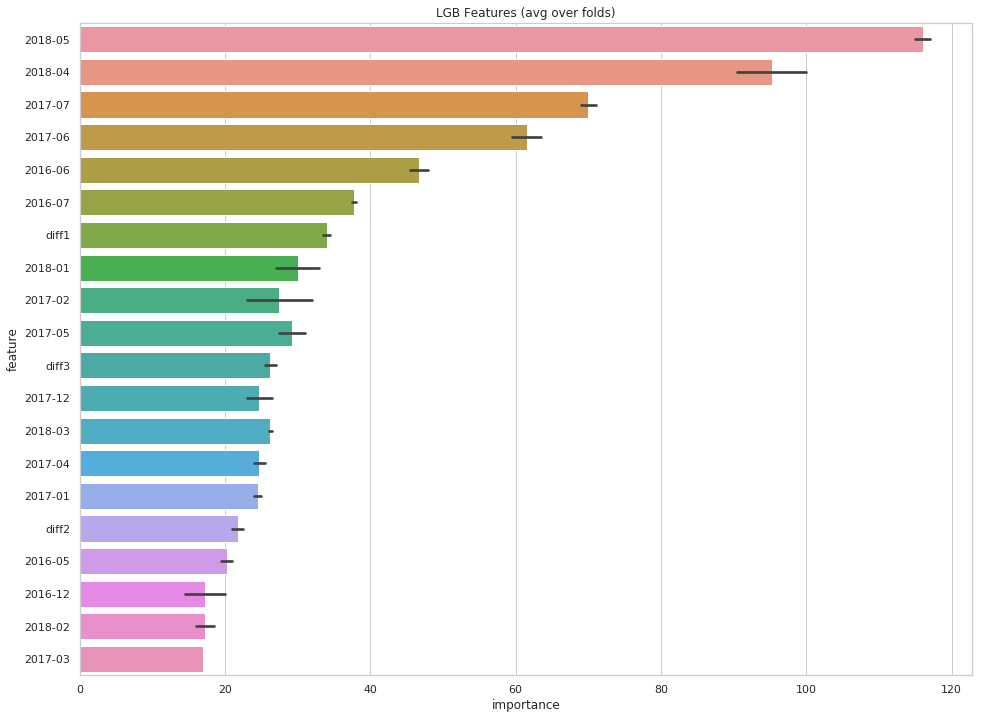

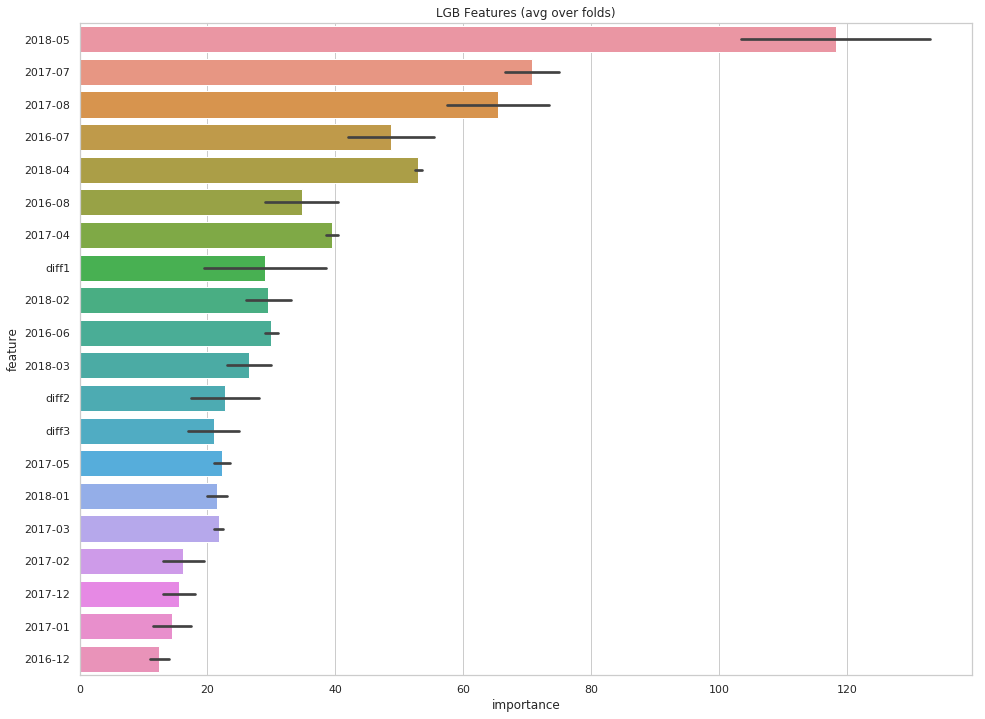

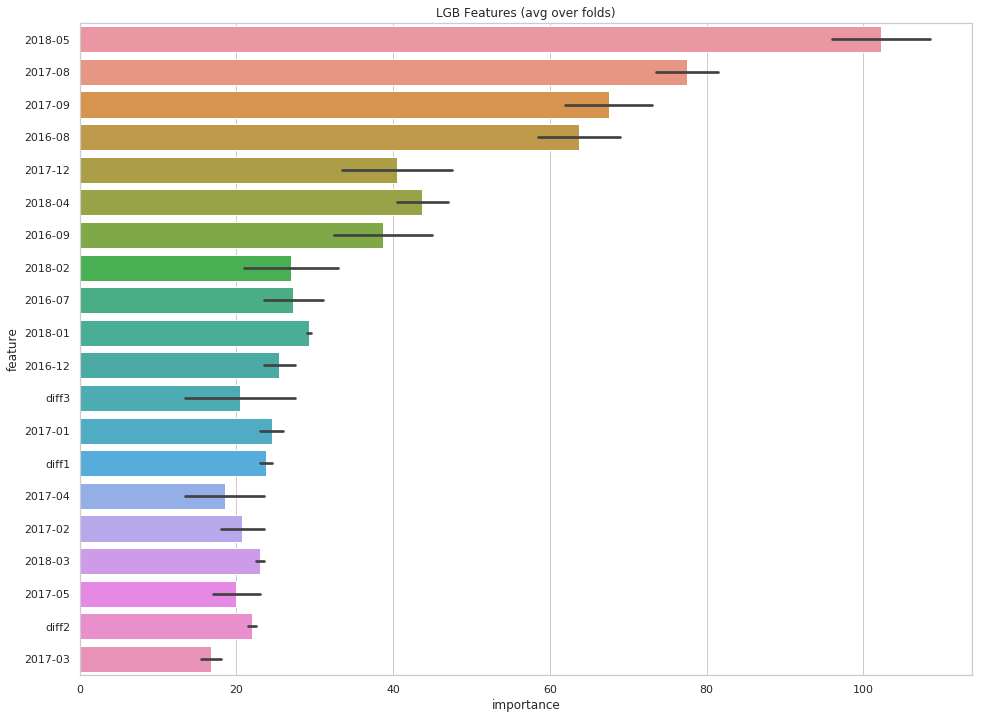

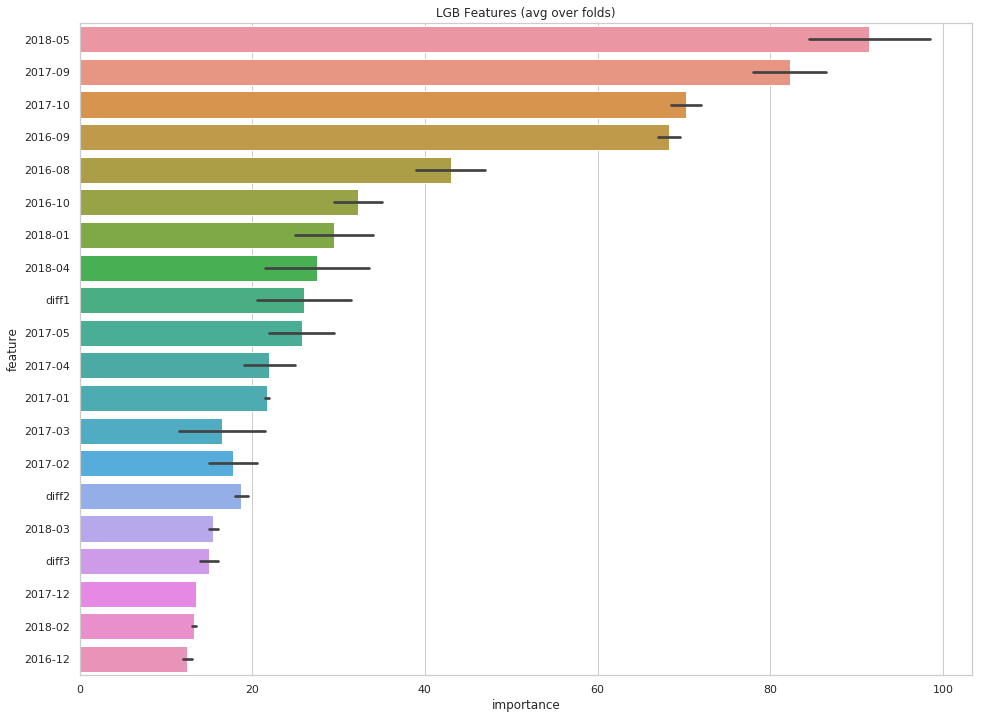

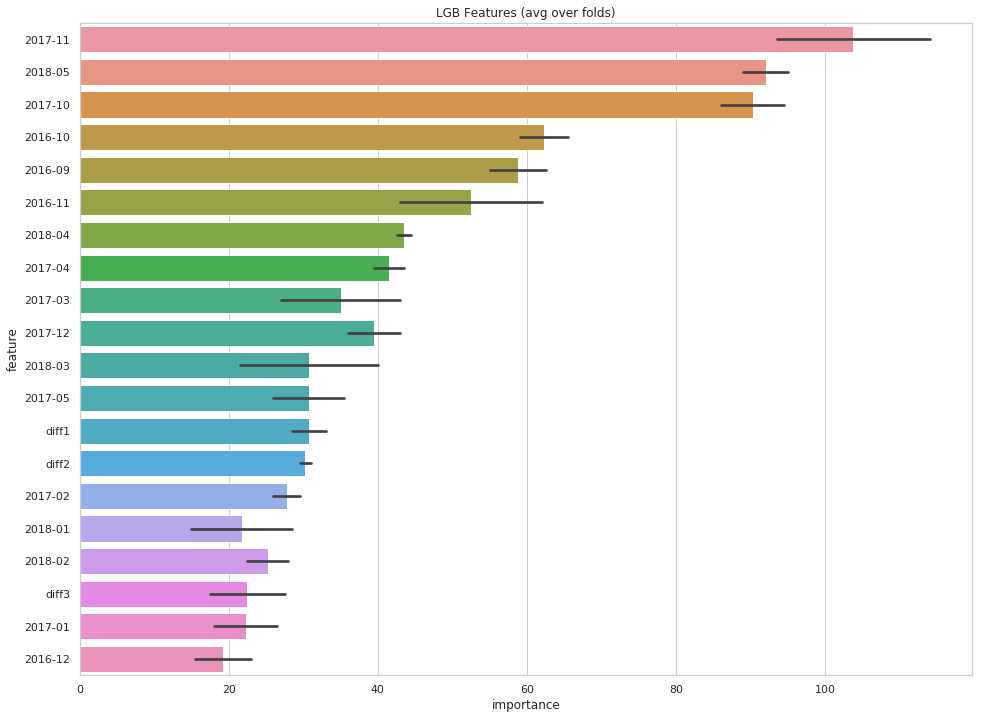

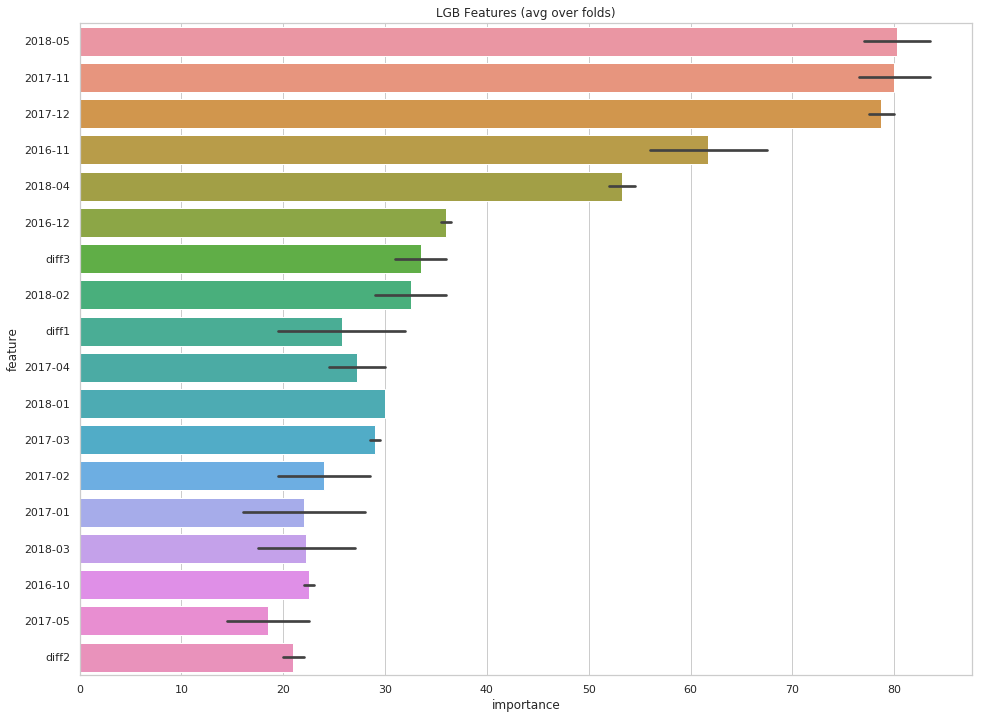

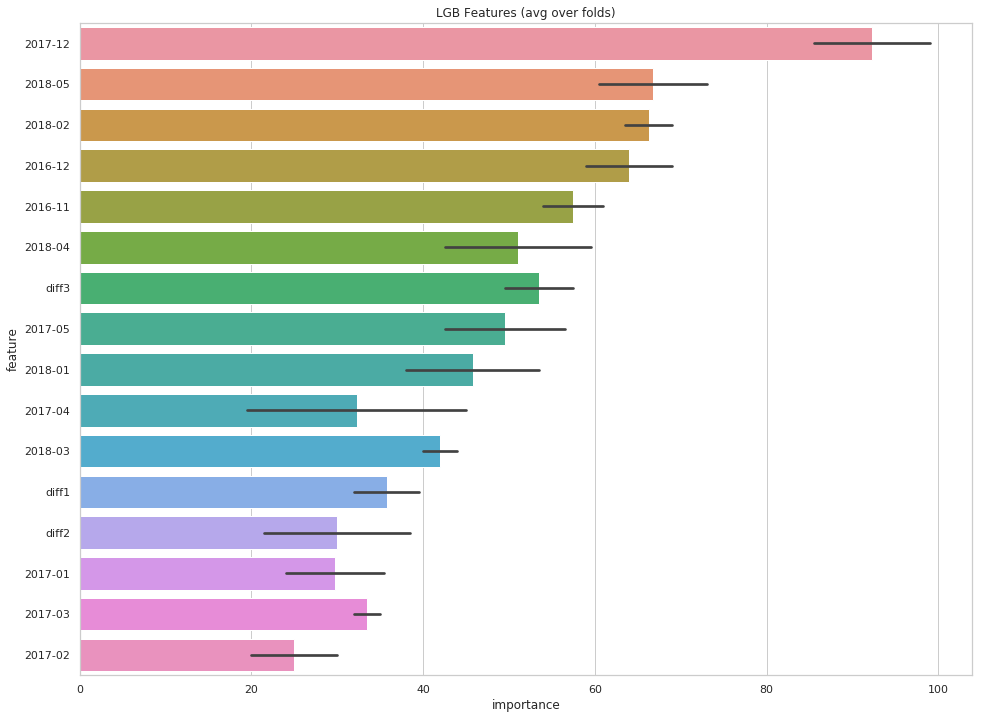

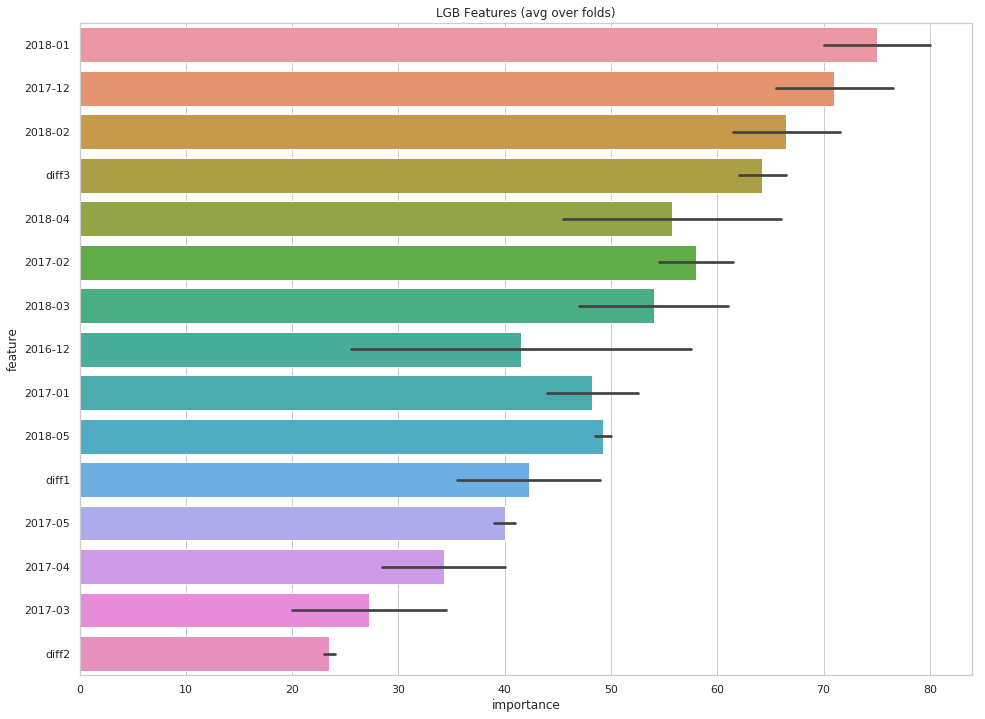

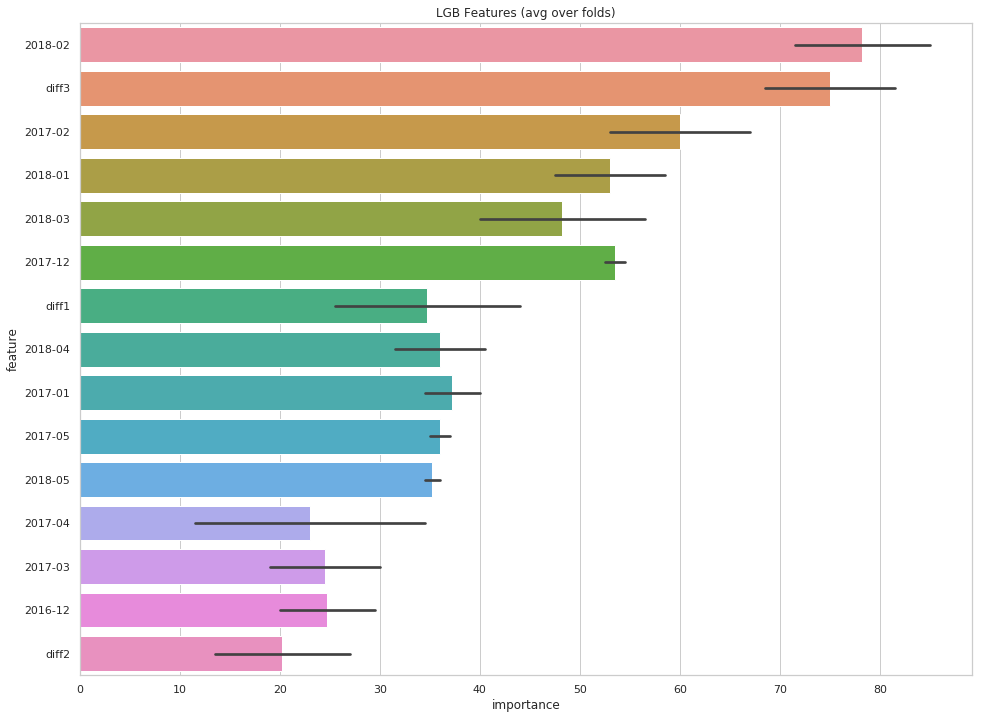

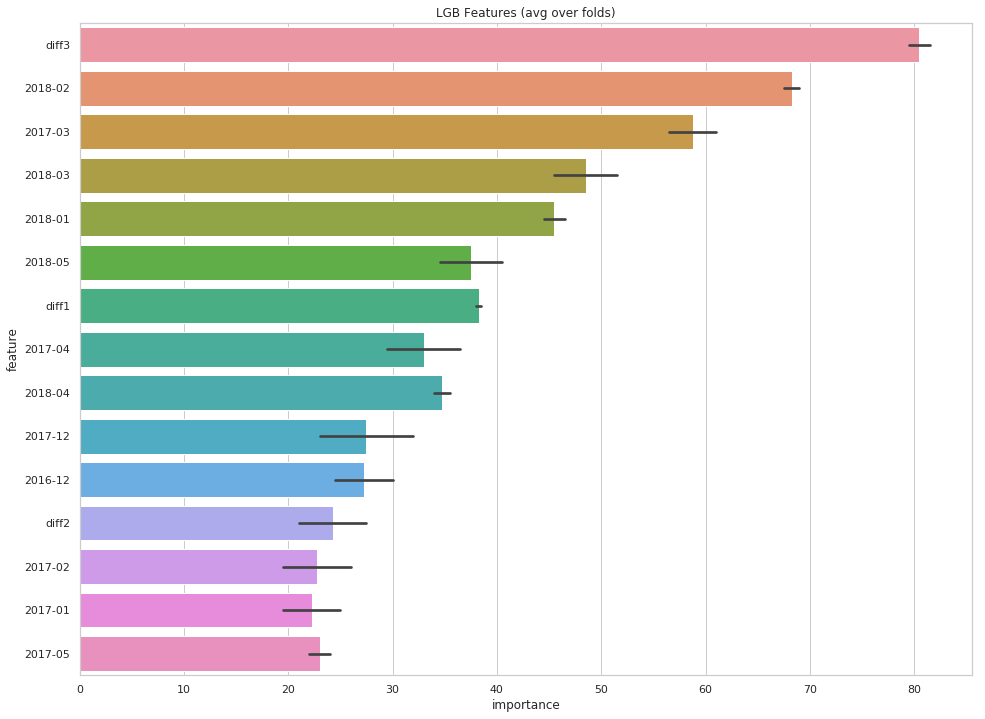

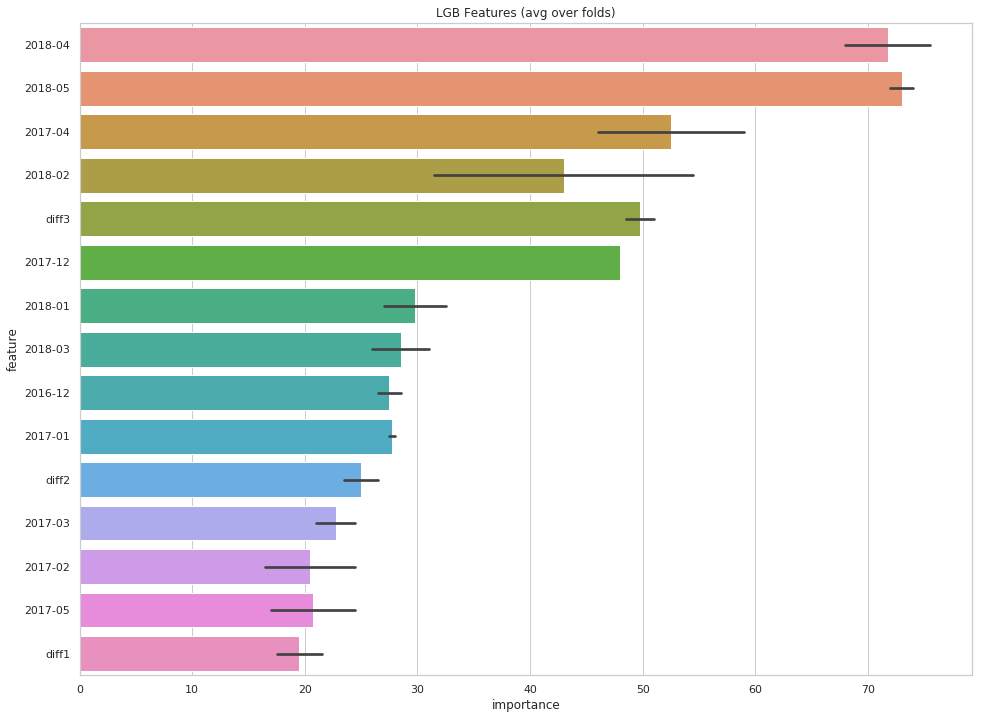

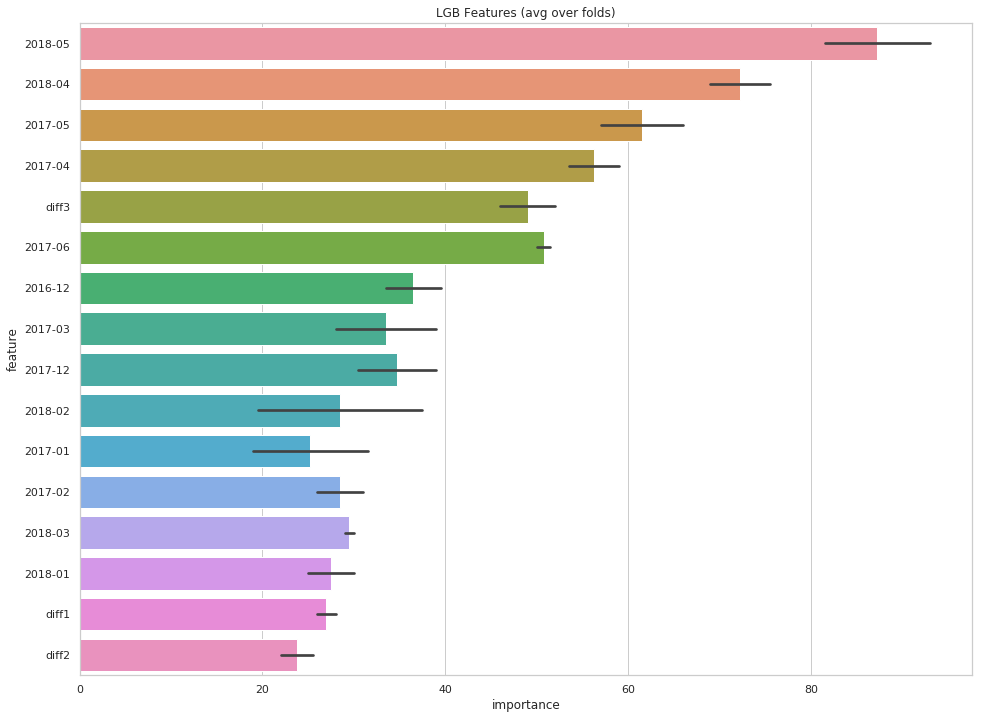

In [725]:
from tqdm import tqdm

sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

folds = KFold(n_splits=10, shuffle=True, random_state=7)
score_list = []

#from sklearn.preprocessing import StandardScaler
#train[list(test.columns)] = StandardScaler().fit_transform(train[list(test.columns)])
#test[list(test.columns)] = StandardScaler().fit_transform(test[list(test.columns)])

test_columns = list(sample_submission.columns[1:])
for idx, month in tqdm(enumerate(test_columns)): 
    
    print("month:", month)
    
    
    #to_add = [all_cols[idx-i] for i in [23,24,25,35,36,37,47,48,49]]
    #to_add = [elem for elem in to_add if elem in test.columns]
    
    columns = [all_cols[idx-22], all_cols[idx-23], all_cols[idx-24], all_cols[idx-23], all_cols[idx-22], 
               all_cols[idx-38], all_cols[idx-37], all_cols[idx-36], all_cols[idx-35], all_cols[idx-34],]
               #all_cols[idx-50], all_cols[idx-49], all_cols[idx-48], all_cols[idx-47], all_cols[idx-46]]
    columns_rolling = [all_cols[idx-24], all_cols[idx-36]]#, all_cols[idx-48]]
    
    train_df, index_list = fe(36+idx, train, list(test.columns), columns, columns_rolling)
    test_df, _ = fe(36+idx, test, list(test.columns), columns, columns_rolling, True)
    
    if TRAINING: 
        cols = [c for c in train_df.columns if c not in ['target']]
        X = train_df[cols]
        y = train_df['target']
    
    X_test = test_df[cols]
    
    result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, model_type=MODEL_TYPE, eval_metric='rmse', plot_feature_importance=True,
                                                          early_stopping_rounds=150)
    score_list.append(np.mean(result_dict_lgb['scores']))
    sample_submission[month] = result_dict_lgb['prediction']

print()
print("--------------------")
print(score_list)
print("score:", np.mean(score_list))

In [718]:
round(np.mean(score_list),5)

19.41567

In [726]:
score = round(np.mean(score_list),5)

sample_submission.to_csv('../code/submission'+'_'+str(score).replace('.', '_')+'.csv', index=False)
pd.read_csv('../code/'+'submission'+'_'+str(score).replace('.', '_')+'.csv')

,id,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05
0,78587,21.616624,17.353758,10.174006,9.297568,17.200512,33.666235,55.794241,87.781713,84.102976,63.671794,56.266818,31.968280
1,78588,22.308431,17.610326,11.629217,9.624143,16.318069,26.237495,40.284247,81.333553,80.325554,66.282371,51.583318,35.484245
2,78589,13.779034,10.361562,6.831962,7.975805,13.028358,24.034914,47.433435,81.918746,78.201230,53.758854,40.913788,19.823828
3,78590,21.375103,14.548976,10.426987,12.657758,16.567167,25.178782,40.642122,75.321031,70.039659,61.535025,50.846184,35.409525
4,78591,18.524980,15.890780,11.332457,11.717986,19.295183,28.003868,53.884133,86.559382,82.152311,65.970862,52.326016,27.639870
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,88582,24.162223,15.431230,8.785821,11.858224,21.008592,40.316850,79.944522,157.891952,144.865356,101.143588,73.234743,39.153229
9996,88583,26.558630,13.245786,7.314135,8.123461,16.779073,47.888851,89.260796,195.278282,173.580024,130.762661,105.231396,54.088849
9997,88584,6.770748,4.782436,2.665100,3.180072,5.735611,9.387203,15.087299,32.032116,29.477457,19.836919,17.480776,10.215172
9998,88585,12.477247,7.768139,4.218579,4.479740,8.492642,14.933940,32.990075,59.072968,58.349146,43.990147,33.401901,21.593360


In [342]:
[9.553154557324277, 7.987681986825339, 6.642130662834548, 6.859203932826457, 
 9.865994440731416, 18.701677483540827, 27.315012425643552, 39.07730151015876]
score: 15.750269624985648

[9.573002497836292,
 7.892065242124982,
 6.667031888588962,
 6.856590606462325,
 9.868063417455371,
 18.727905923505944,
 27.495785352829607,
 39.32670350998595]

In [442]:
train[train['2019-01']==0]

,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05
20,5.93,11.87,3.95,6.92,6.92,12.86,20.77,54.41,57.37,36.57,19.76,10.87,9.88,9.88,3.95,5.93,9.88,12.84,24.71,26.68,39.53,31.61,26.67,10.86,8.89,8.89,3.95,5.92,9.88,18.77,50.39,68.17,99.79,50.40,31.62,10.87,8.89,8.89,1.97,2.96,7.90,18.77,32.61,0.0,85.98,39.53,0.00,15.81
21,1.97,0.98,1.97,1.97,4.94,7.91,7.91,12.86,0.98,2.96,1.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
35,14.83,12.86,8.90,8.90,13.85,18.79,43.52,87.05,109.81,96.86,0.00,0.00,3.95,15.81,5.93,3.95,8.89,25.69,127.50,111.68,140.35,89.91,91.89,20.75,12.84,6.91,2.96,1.97,4.94,39.52,102.76,181.81,154.14,151.20,84.00,34.59,10.87,8.89,1.97,5.92,3.95,21.74,99.81,0.0,0.00,0.00,0.00,36.57
44,33.63,16.81,0.00,10.88,8.90,35.61,11.87,69.25,277.99,6.91,50.40,26.68,25.69,16.80,0.00,0.00,7.90,35.58,0.00,0.00,0.00,159.08,46.44,55.33,25.69,4.94,0.00,0.00,43.47,22.72,26.67,0.00,206.51,75.11,51.39,49.41,9.88,0.00,0.00,43.48,43.48,22.73,26.68,0.0,133.42,75.11,266.86,49.42
46,34.62,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,32.61,53.37,9.88,7.90,5.93,3.95,2.96,4.94,10.87,36.57,66.22,111.68,84.97,54.34,18.77,9.88,2.96,1.97,1.97,4.94,6.91,51.38,106.71,107.70,99.81,27.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65690,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,10.87,6.91,8.89,5.93
65710,0.00,12.86,0.00,0.00,0.98,0.00,9.89,14.83,21.76,8.89,0.98,0.00,0.98,0.00,0.98,0.00,0.98,0.98,10.87,12.84,28.66,22.72,5.92,0.98,0.00,0.98,0.98,0.00,0.98,1.97,24.70,40.51,30.63,16.80,2.96,0.98,0.00,50.40,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
65728,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
65753,3.95,3.95,0.98,0.98,0.98,0.00,0.00,34.62,32.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.98,0.00,0.00,0.00,0.00,1.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.98,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,20.75,0.98,0.00,0.00


In [443]:
train['2018-01'].describe()

count    65785.000000
mean        93.514753
std         66.628059
min          0.000000
25%         39.520000
50%         85.960000
75%        138.330000
max        331.010000
Name: 2018-01, dtype: float64

In [444]:
test['2018-01'].describe()

count    10000.000000
mean        82.680122
std         49.463952
min          0.000000
25%         45.450000
50%         78.050000
75%        113.630000
max        331.010000
Name: 2018-01, dtype: float64

In [446]:
np.histogram(test['2018-01'])

(array([1630, 2479, 2463, 1877,  965,  407,  115,   48,   11,    5]),
 array([  0.   ,  33.101,  66.202,  99.303, 132.404, 165.505, 198.606,
        231.707, 264.808, 297.909, 331.01 ]))

In [447]:
np.histogram(train['2018-01'])

(array([14366, 11804, 11517, 10273,  7782,  5282,  2666,  1253,   597,
          245]),
 array([  0.   ,  33.101,  66.202,  99.303, 132.404, 165.505, 198.606,
        231.707, 264.808, 297.909, 331.01 ]))

In [ ]:
mean_squared_error(y.loc[valid_index],result_dict_lgb['oof'])**0.5

In [ ]:
mean_squared_error(y.loc[valid_index],result_dict_lgb['oof'])**0.5

In [366]:
import copy
tmp = copy.copy(X.loc[valid_index])
tmp['y'] = y.loc[valid_index]
tmp['pred'] = result_dict_lgb['oof']

In [442]:
index_list

[0,
 1,
 2,
 3,
 5,
 6,
 8,
 9,
 10,
 11,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 22,
 23,
 24,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 45,
 46,
 47,
 48,
 51,
 52,
 54,
 55,
 56,
 57,
 58,
 59,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 83,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 109,
 110,
 111,
 112,
 113,
 115,
 116,
 117,
 118,
 119,
 121,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 158,
 160,
 161,
 163,
 166,
 168,
 170,
 171,
 172,
 174,
 175,
 176,
 177,
 179,
 180,
 181,
 182,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 194,
 195,
 196,
 197,
 198,
 200,
 202,
 205,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 2

In [495]:
train.loc[index_list, ['2016-01','2017-01','2018-01','2018-03','2018-04','2018-05']].loc[[index_list[i] for i in valid_index]].head(20)

,2016-01,2017-01,2018-01,2018-03,2018-04,2018-05
0,26.71,5.93,6.91,8.89,9.88,7.90
1,44.51,41.51,113.63,88.94,54.35,37.55
5,130.58,113.66,108.69,90.92,97.84,0.00
6,84.09,128.49,97.82,58.30,61.27,32.61
8,50.45,39.53,71.14,68.19,65.22,37.55
9,20.77,40.52,61.26,82.02,41.50,9.88
11,118.71,133.43,117.58,115.63,48.42,29.64
13,97.94,95.87,104.73,109.70,39.53,22.73
14,18.79,14.82,51.38,46.45,21.74,9.88
17,135.53,138.37,131.41,109.70,81.04,35.57


In [438]:
test

,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
0,14.83,14.83,14.83,13.85,10.88,18.79,46.49,73.20,84.09,74.13,49.42,39.53,19.76,8.89,8.89,6.91,10.87,33.60,64.24,69.18,82.03,76.08,74.10,23.71,15.80,16.79,12.84,9.88,14.82,27.66,66.20,83.98,93.86,79.06,53.36,33.60
1,36.60,22.75,18.79,14.83,20.77,25.72,54.41,81.12,78.15,89.94,83.02,76.10,14.82,20.75,18.77,7.90,19.76,30.64,20.75,101.80,83.02,77.07,81.02,51.38,25.69,15.80,10.86,8.89,9.88,23.71,44.46,82.01,92.88,79.06,55.34,26.68
2,9.89,9.89,11.87,9.89,14.83,16.81,42.53,68.26,100.90,69.18,47.44,14.82,10.87,10.87,7.90,9.88,8.89,30.64,52.38,67.21,78.08,60.27,38.53,14.82,12.84,10.86,7.90,7.90,10.86,20.75,59.28,81.02,92.88,69.18,38.54,14.82
3,12.86,19.78,13.85,11.87,18.79,20.77,49.46,60.34,88.04,85.00,55.35,25.69,20.75,14.82,12.84,18.77,9.88,25.69,56.33,91.92,73.14,84.97,63.23,34.58,10.86,8.89,7.90,9.88,12.84,8.89,34.58,64.22,64.22,64.23,49.41,39.53
4,16.81,12.86,11.87,13.85,18.79,20.77,37.59,91.01,97.94,67.21,36.57,19.76,16.80,17.79,10.87,13.83,19.76,36.57,64.24,73.14,82.03,74.10,61.26,19.76,14.82,13.83,14.82,13.83,15.80,23.71,60.27,83.98,82.01,88.94,57.32,22.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,13.85,12.86,9.89,6.92,14.83,43.52,63.31,86.06,116.73,80.06,57.32,39.53,21.74,6.91,10.87,9.88,27.67,45.46,100.81,155.17,197.68,132.40,78.05,33.59,24.70,14.82,8.89,13.83,16.79,28.65,86.95,178.84,167.97,119.58,79.06,35.57
9996,13.85,13.85,10.88,9.89,12.86,14.83,31.65,61.33,107.83,106.74,58.31,49.42,19.76,10.87,8.89,6.91,10.87,15.81,52.38,57.32,113.66,88.92,83.00,29.64,12.84,7.90,4.94,7.90,7.90,44.46,119.56,222.32,249.98,211.49,114.64,52.37
9997,3.95,1.97,0.98,0.98,5.93,7.91,33.63,55.40,81.12,34.59,5.93,3.95,4.94,4.94,4.94,1.97,8.89,5.93,10.87,11.86,8.89,4.94,15.80,5.92,4.94,1.97,1.97,0.98,3.95,8.89,15.80,35.57,38.53,11.85,12.84,8.89
9998,16.81,6.92,4.94,7.91,7.91,11.87,18.79,41.55,22.75,68.19,19.76,18.77,16.80,0.00,0.98,8.89,9.88,10.87,12.84,26.68,25.69,21.73,19.76,20.75,18.77,1.97,4.94,2.96,2.96,8.89,49.40,49.40,78.05,64.23,37.55,11.85


0          9.88
1        145.28
4         74.12
5         73.13
6         79.06
          ...  
55326      0.00
55328     58.30
55330    296.49
55332     46.45
55335     55.34
Name: target, Length: 27668, dtype: float64

In [508]:
tmp2 = copy.copy(train.loc[index_list, ['2017-03','2017-04','2017-05','2018-03','2018-04','2018-05','2016-01','2017-01','2018-01']].loc[[index_list[i] for i in valid_index]])
tmp2['y'] = list(y.loc[valid_index])
tmp2['pred'] = result_dict_lgb['oof']
tmp2.loc[100:140]

,2017-03,2017-04,2017-05,2018-03,2018-04,2018-05,2016-01,2017-01,2018-01,y,pred
101,32.60,41.50,30.63,124.52,90.92,26.68,23.74,29.65,91.89,122.54,108.131196
102,97.82,79.04,26.67,119.58,79.06,44.47,79.14,104.77,118.57,138.36,134.902642
109,91.89,84.97,47.42,88.94,56.33,42.49,149.38,130.46,118.57,126.50,108.760289
115,64.22,46.44,22.72,0.98,3.95,2.96,67.27,67.21,67.19,65.22,58.638073
117,71.14,57.30,30.63,73.13,47.43,30.63,61.33,77.09,84.97,13.83,80.133043
121,110.66,94.85,42.48,216.43,120.57,87.95,178.07,138.37,195.64,244.11,180.450796
124,147.22,67.19,25.69,128.47,90.92,27.67,169.17,105.75,191.69,193.70,178.603180
129,14.82,17.78,12.84,18.77,11.85,9.88,71.22,28.66,43.47,29.64,43.005109
131,157.10,124.50,37.54,181.84,157.13,77.08,213.68,203.61,245.04,274.74,228.338004
133,18.77,12.84,8.89,52.37,30.63,19.76,26.71,20.75,49.40,59.29,55.540428


In [ ]:
2016-01	2017-01	2018-01 의 유사성 std
2017-03	2018-03, 2017-04	2018-04, 2017-05	2018-05 : 3개의 유사성

In [454]:
train.loc[[0], ['2016-01', '2017-01', '2019-01']]

,2016-01,2017-01,2019-01
0,26.71,5.93,9.88


In [417]:
index_list[-10:]

[65773, 65774, 65777, 65778, 65779, 65780, 65781, 65782, 65783, 65784]

In [401]:
y.loc[valid_index].index

Int64Index([    0,     1,     4,     5,     6,     7,     9,    10,    11,
               14,
            ...
            55320, 55321, 55323, 55324, 55325, 55326, 55328, 55330, 55332,
            55335],
           dtype='int64', length=27668)

,2016-01,2017-01,2018-01,2018-03,2018-04,2018-05,y,pred
0,26.71,5.93,6.91,8.89,9.88,7.90,9.88,18.541510
1,44.51,41.51,113.63,88.94,54.35,37.55,145.28,97.504555
4,NaN,NaN,NaN,NaN,NaN,NaN,74.12,117.937491
5,130.58,113.66,108.69,90.92,97.84,0.00,73.13,91.119250
6,84.09,128.49,97.82,58.30,61.27,32.61,79.06,63.530209
...,...,...,...,...,...,...,...,...
55326,75.18,97.85,19.76,110.68,81.04,67.20,0.00,90.776610
55328,6.92,8.89,7.90,8.89,7.90,6.91,58.30,61.820382
55330,40.56,101.80,49.40,72.14,39.53,13.83,296.49,216.581270
55332,140.48,111.68,218.37,169.98,108.71,58.30,46.45,55.996886


In [376]:
X.loc[valid_index]

,2018-03,2018-02,2018-01,2016-11,2016-12,2017-01,2017-02,2017-03,2015-11,2015-12,2016-01,2016-02,2016-03,rolling_mean_2018-01_3,rolling_std_2018-01_3,rolling_min_2018-01_3,rolling_max_2018-01_3,rolling_mean_2017-01_3,rolling_std_2017-01_3,rolling_min_2017-01_3,rolling_max_2017-01_3,rolling_mean_2016-01_3,rolling_std_2016-01_3,rolling_min_2016-01_3,rolling_max_2016-01_3,rolling_mean_diff_3,rolling_mean_2018-01_5,rolling_std_2018-01_5,rolling_min_2018-01_5,rolling_max_2018-01_5,rolling_mean_2017-01_5,rolling_std_2017-01_5,rolling_min_2017-01_5,rolling_max_2017-01_5,rolling_mean_2016-01_5,rolling_std_2016-01_5,rolling_min_2016-01_5,rolling_max_2016-01_5,rolling_mean_diff_5,yearly_mean,yearly_std,yearly_max,yearly_min,yearly_max_min,yearly_diff1,yearly_diff2,recent_mean_6,recent_mean_6_80,recent_mean_6_20,recent_mean_3,recent_mean_3_80,recent_mean_3_20,recent_mean_2,recent_mean_2_80,recent_mean_2_20,recent_std_6,recent_std_3,recent_std_2,recent_diff1,recent_diff2,recent_diff3,zero_count,zero_count_recent
0,8.89,0.00,6.91,6.91,10.87,5.93,3.95,3.95,8.90,12.86,26.71,35.61,31.62,6.91,4.303839,0.00,7.90,5.93,3.563949,3.95,10.87,26.71,11.464401,12.86,35.61,0.98,6.91,3.519371,0.00,8.89,5.93,2.847652,3.95,10.87,26.71,11.711236,8.90,35.61,0.98,6.91,11.724681,26.71,5.93,20.78,0.98,-19.80,7.900,8.89,6.91,8.89,9.484,8.296,8.890,9.484,8.296,3.534106,0.990000,1.400071,-1.98,-0.99,7.90,2,1
1,88.94,118.57,113.63,21.74,40.52,41.51,88.95,79.04,10.88,19.78,44.51,62.32,47.44,113.63,35.742600,54.34,118.57,41.51,27.679712,40.52,88.95,44.51,21.363601,19.78,62.32,72.12,88.94,41.777108,19.76,118.57,41.51,28.400276,21.74,88.95,44.51,21.126275,10.88,62.32,47.43,44.51,40.800059,113.63,41.51,72.12,72.12,69.12,71.645,113.63,54.34,54.35,75.104,44.270,45.950,50.990,40.910,34.030463,26.203181,11.879394,-16.80,-51.39,-81.02,0,0
4,90.92,111.65,108.69,19.76,71.16,113.66,192.73,27.66,31.65,81.12,130.58,110.80,29.65,108.69,20.877549,74.10,111.65,113.66,61.694921,71.16,192.73,110.80,24.894586,81.12,130.58,-4.97,90.92,37.020235,20.75,111.65,71.16,70.997935,19.76,192.73,81.12,45.630548,29.65,130.58,19.76,113.66,11.475767,130.58,108.69,21.89,-4.97,-21.89,94.380,108.69,74.10,90.92,95.072,36.368,48.920,78.272,19.568,41.702407,54.600059,69.183327,-97.84,-90.92,-111.65,1,1
5,58.30,98.81,97.82,37.55,49.42,128.49,88.95,64.22,20.77,52.43,84.09,115.74,83.02,97.82,15.126018,72.13,98.81,88.95,39.535000,49.42,128.49,84.09,31.655000,52.43,115.74,8.87,72.13,24.943690,41.50,98.81,64.22,36.127256,37.55,128.49,83.02,36.004074,20.77,115.74,7.91,97.82,22.732216,128.49,84.09,44.40,-30.67,13.73,66.700,97.82,58.30,58.30,60.082,42.886,46.940,55.538,38.342,25.375079,15.759614,20.265680,-28.66,-25.69,-66.20,2,0
6,68.19,78.05,71.14,14.82,25.69,39.53,67.21,47.42,12.86,19.78,50.45,84.09,80.06,71.14,31.846969,19.76,78.05,39.53,21.140949,25.69,67.21,50.45,32.166428,19.78,84.09,31.61,68.19,29.085956,19.76,78.05,39.53,20.179124,14.82,67.21,50.45,33.003934,12.86,84.09,28.66,50.45,16.054670,71.14,39.53,31.61,31.61,20.69,66.705,71.14,37.55,65.22,67.002,48.618,51.385,59.686,43.084,22.804467,16.898025,19.565645,-27.67,-30.64,-40.50,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55326,84.99,85.96,97.82,76.10,87.96,72.15,70.17,47.42,19.78,39.57,79.14,98.93,79.07,85.96,11.368593,75.09,97.82,72.15,9.749877,70.17,87.96,79.14,30.224269,39.57,98.93,13.81,84.99,15.514655,56.32,97.82,72.15,14.759670,47.42,87.96,79.07,32.504610,19.78,98.93,12.84,79.14,13.271218,97.82,72.15,25.67,25.67,18.68,80.040,85.96,68.19,68.19,78.270,53.958,56.330,63.446,49.214,18.504346,20.358245,16.772573,-23.72,-40.52,-41.49,1,0
55328,45.46,73.11,60.27,14.82,37.55,48.43,71.16,28.65,16.81,24.73,27.70,51.44,37.55,60.27,22.881512,28.65,73.11,48.43,17.149633,37.55,71.16,27.70,14.639175,24.73,51.44,11.84,45.46,26.073239,6.91,73.11,37.55,2

In [379]:
train.loc[index_list, ['2018-01','2017-01','2016-01','y','pred' ]]

/home/dohee/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,2018-01,2017-01,2016-01,y,pred
0,6.91,5.93,26.71,NaN,NaN
1,113.63,41.51,44.51,NaN,NaN
2,175.88,27.67,78.15,NaN,NaN
3,195.64,25.69,79.14,NaN,NaN
5,108.69,113.66,130.58,NaN,NaN
...,...,...,...,...,...
65780,126.47,63.25,72.21,NaN,NaN
65781,46.44,45.46,54.41,NaN,NaN
65782,23.71,23.72,21.76,NaN,NaN
65783,112.64,80.06,85.07,NaN,NaN


In [367]:
tmp[['2018-01','2017-01','2016-01','y','pred' ]].head(20)

,2018-01,2017-01,2016-01,y,pred
0,6.91,5.93,26.71,9.88,18.541510
1,113.63,41.51,44.51,145.28,97.504555
4,108.69,113.66,130.58,74.12,117.937491
5,97.82,128.49,84.09,73.13,91.119250
6,71.14,39.53,50.45,79.06,63.530209
7,61.26,40.52,20.77,56.33,74.276925
9,117.58,133.43,118.71,115.63,110.741929
10,104.73,95.87,97.94,125.51,102.180794
11,51.38,14.82,18.79,34.59,45.102695
14,131.41,138.37,135.53,149.23,132.805877


In [299]:
X.loc[valid_index]

,2018-05,2017-03,2017-04,2017-05,2017-06,2017-07,2016-03,2016-04,2016-05,2016-06,2016-07,rolling_mean_2018-05_3,rolling_std_2018-05_3,rolling_min_2018-05_3,rolling_max_2018-05_3,rolling_mean_2017-05_3,rolling_std_2017-05_3,rolling_min_2017-05_3,rolling_max_2017-05_3,rolling_mean_2016-05_3,rolling_std_2016-05_3,rolling_min_2016-05_3,rolling_max_2016-05_3,rolling_mean_diff_3,rolling_mean_2018-05_5,rolling_std_2018-05_5,rolling_min_2018-05_5,rolling_max_2018-05_5,rolling_mean_2017-05_5,rolling_std_2017-05_5,rolling_min_2017-05_5,rolling_max_2017-05_5,rolling_mean_2016-05_5,rolling_std_2016-05_5,rolling_min_2016-05_5,rolling_max_2016-05_5,rolling_mean_diff_5,yearly_mean,yearly_std,yearly_max,yearly_min,yearly_max_min,yearly_diff1,yearly_diff2,recent_mean_6,recent_mean_6_80,recent_mean_6_20,recent_mean_3,recent_mean_3_80,recent_mean_3_20,recent_mean_2,recent_mean_2_80,recent_mean_2_20,recent_std_6,recent_std_3,recent_std_2,recent_diff1,recent_diff2,recent_diff3,zero_count,zero_count_recent
0,7.90,3.95,5.92,4.94,4.94,4.94,31.62,11.86,6.91,3.95,2.96,7.90,3.019045,3.95,9.88,4.94,0.565803,4.94,5.92,6.91,3.996503,3.95,11.86,2.96,7.90,3.738563,0.98,9.88,4.94,0.696506,3.95,5.92,6.91,11.789171,2.96,31.62,2.96,6.91,1.506796,7.90,4.94,2.96,2.96,0.99,7.900,8.89,6.91,8.89,9.484,8.296,8.890,9.484,8.296,3.534106,0.990000,1.400071,-1.98,-0.99,7.90,2,1
1,37.55,79.04,39.52,29.64,16.79,16.79,47.44,30.64,20.75,19.76,6.91,37.55,13.940503,26.68,54.35,29.64,11.397294,16.79,39.52,20.75,6.016181,19.76,30.64,7.91,37.55,27.364187,20.75,88.94,29.64,25.703580,16.79,79.04,20.75,15.067194,6.91,47.44,7.91,29.64,8.404763,37.55,20.75,16.80,7.91,16.80,71.645,113.63,54.34,54.35,75.104,44.270,45.950,50.990,40.910,34.030463,26.203181,11.879394,-16.80,-51.39,-81.02,0,0
4,0.00,27.66,91.89,23.71,29.64,20.75,29.65,197.68,59.30,38.54,19.76,0.00,56.487950,0.00,97.84,29.64,37.768461,23.71,91.89,59.30,86.511600,38.54,197.68,-29.64,0.00,51.751919,0.00,97.84,27.66,29.916715,20.75,91.89,38.54,73.405455,19.76,197.68,-27.66,23.71,29.847675,59.30,0.00,59.30,-23.71,-59.30,94.380,108.69,74.10,90.92,95.072,36.368,48.920,78.272,19.568,41.702407,54.600059,69.183327,-97.84,-90.92,-111.65,1,1
5,32.61,64.22,61.26,20.75,21.73,8.89,83.02,84.01,54.36,23.72,10.87,32.61,24.815014,11.85,61.27,21.73,23.110753,20.75,61.26,54.36,30.146355,23.72,84.01,10.88,32.61,24.776523,8.89,61.27,21.73,25.512737,8.89,64.22,54.36,33.468841,10.87,84.01,10.88,32.61,17.045792,54.36,20.75,33.61,11.86,-21.75,66.700,97.82,58.30,58.30,60.082,42.886,46.940,55.538,38.342,25.375079,15.759614,20.265680,-28.66,-25.69,-66.20,2,0
6,37.55,47.42,31.61,24.70,16.79,12.84,80.06,60.29,16.80,17.79,15.81,37.55,25.720288,13.83,65.22,24.70,7.415621,16.79,31.61,17.79,24.828110,16.80,60.29,12.85,37.55,26.246894,13.83,68.19,24.70,13.672329,12.84,47.42,17.79,30.066823,15.81,80.06,12.85,24.70,10.472941,37.55,16.80,20.75,12.85,20.75,66.705,71.14,37.55,65.22,67.002,48.618,51.385,59.686,43.084,22.804467,16.898025,19.565645,-27.67,-30.64,-40.50,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55326,44.47,47.42,58.29,41.50,13.83,6.91,79.07,69.18,81.04,0.00,4.94,44.47,26.228796,15.81,68.19,41.50,22.450778,13.83,58.29,69.18,43.768355,0.00,81.04,2.97,44.47,35.311750,0.00,84.99,41.50,22.170966,6.91,58.29,69.18,40.795477,0.00,81.04,2.97,44.47,22.021192,81.04,41.50,39.54,2.97,-36.57,80.040,85.96,68.19,68.19,78.270,53.958,56.330,63.446,49.214,18.504346,20.358245,16.772573,-23.72,-40.52,-41.49,1,0
55328,14.82,28.65,20.75,9.88,9.88,8.89,37.55,17.79,13.83,8.89,7.90,14.82,8.556331,14.82,29.64,9.88,6.275797,9.88,20.75,13.83,4.458983,8.89,17.79,4.94,14.82,14.615672,9.88,45.46,9.88,8.764779,8.89,28.65,13.83,12.055842,7.90,37.55,4.94,13.83,2.613625,14.82,9.88,4.94,4.94,0.99,37.550,60.27,28.65,29.64,39.132,20.748,22.230,26.676,17.784,21.832731,15.322720,10.479322

In [296]:
for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
    print(fold_n)

0
1


In [297]:
valid_index

array([    0,     1,     4, ..., 55330, 55332, 55335])

In [207]:
X['zero_count_recent'].mean()

0.11950242110535983

In [208]:
X_test[X_test['zero_count_recent']==6]

,2018-05,2017-03,2017-04,2017-05,2017-06,2017-07,2016-03,2016-04,2016-05,2016-06,2016-07,rolling_mean_2018-05_3,rolling_std_2018-05_3,rolling_min_2018-05_3,rolling_max_2018-05_3,rolling_mean_2017-05_3,rolling_std_2017-05_3,rolling_min_2017-05_3,rolling_max_2017-05_3,rolling_mean_2016-05_3,rolling_std_2016-05_3,rolling_min_2016-05_3,rolling_max_2016-05_3,rolling_mean_diff_3,rolling_mean_2018-05_5,rolling_std_2018-05_5,rolling_min_2018-05_5,rolling_max_2018-05_5,rolling_mean_2017-05_5,rolling_std_2017-05_5,rolling_min_2017-05_5,rolling_max_2017-05_5,rolling_mean_2016-05_5,rolling_std_2016-05_5,rolling_min_2016-05_5,rolling_max_2016-05_5,rolling_mean_diff_5,yearly_mean,yearly_std,yearly_max,yearly_min,yearly_max_min,yearly_diff1,yearly_diff2,recent_mean_6,recent_mean_6_80,recent_mean_6_20,recent_mean_3,recent_mean_3_80,recent_mean_3_20,recent_mean_2,recent_mean_2_80,recent_mean_2_20,recent_std_6,recent_std_3,recent_std_2,recent_diff1,recent_diff2,recent_diff3,zero_count,zero_count_recent
271,0.0,34.58,43.47,32.60,24.70,15.80,78.08,38.54,28.66,25.69,20.75,11.85,8.048145,9.88,24.70,7.90,2.055245e+00,6.91,10.86,11.86,8.408486e+00,8.89,24.71,3.95,11.85,13.735284,9.88,41.50,7.90,6.648291,4.94,21.73,11.86,7.940294,6.91,24.71,3.95,28.66,17.793628,32.60,0.0,32.60,-32.60,-28.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,6
955,0.0,71.14,56.32,22.72,14.82,0.00,40.52,34.59,21.74,13.83,11.86,16.80,6.847374,16.80,28.66,19.76,5.704221e+00,19.76,29.64,20.75,3.995677e+00,15.81,23.72,-2.96,16.80,6.187680,14.82,28.66,19.76,4.909547,18.77,29.64,18.77,3.917905,13.83,23.72,-2.96,21.74,12.843847,22.72,0.0,22.72,-22.72,-21.74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,6
1022,0.0,47.42,43.47,22.72,8.89,8.89,50.40,40.52,28.66,10.87,10.87,5.92,2.486148,2.96,7.90,5.92,5.658033e-01,4.94,5.92,9.88,2.060849e+00,6.91,10.87,0.00,5.92,9.084147,2.96,24.70,5.92,0.880454,3.95,5.92,9.88,3.465650,4.94,13.83,0.00,22.72,15.126564,28.66,0.0,28.66,-22.72,-28.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6
1147,0.0,98.81,69.16,49.40,18.77,0.00,59.30,29.65,59.30,39.53,29.65,13.83,7.484713,1.97,15.81,11.85,1.544511e+01,0.00,30.63,10.87,1.284692e+01,9.88,32.61,1.98,11.85,6.156080,1.97,15.81,11.85,19.292766,0.00,48.41,10.87,16.526676,5.93,43.48,0.00,49.40,31.767016,59.30,0.0,59.30,-49.40,-59.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,6
1238,0.0,82.01,41.50,27.66,17.78,0.00,90.93,83.02,40.52,31.62,24.71,19.76,3.742357,13.83,20.75,15.80,1.507890e+00,14.82,17.78,26.68,1.261872e+01,9.88,34.59,3.96,19.76,13.049572,11.85,44.47,15.80,4.419589,11.85,23.71,26.68,14.316709,6.91,38.54,3.96,27.66,20.705577,40.52,0.0,40.52,-27.66,-40.52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,6
1386,0.0,45.45,44.46,25.69,16.79,18.77,50.40,28.66,22.73,15.81,14.82,10.87,15.883508,5.92,35.57,13.83,3.156464e+01,2.96,62.25,7.90,9.133681e+00,7.90,23.72,-2.96,10.87,33.394442,5.92,84.00,13.83,40.999591,0.98,92.88,7.90,22.952213,3.95,59.30,-2.96,22.73,14.055785,25.69,0.0,25.69,-25.69,-22.73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,6
1783,0.0,98.81,107.70,44.46,21.73,15.80,103.78,56.33,53.37,12.84,6.91,13.83,10.568448,12.84,31.62,6.91,1.512250e+00,5.92,8.89,0.98,3.423687e+00,0.98,6.91,6.92,13.83,20.427100,3.95,55.34,6.91,2.360244,3.95,9.88,0.98,29.947260,0.98,69.18,6.92,44.46,28.590315,53.37,0.0,53.37,-44.46,-53.37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6
1835,0.0,71.14,64.22,28.65,18.77,19.76,110.70,53.37,32.61,19.76,18.77,52.37,32.635129,21.74,86.97,60.27,3.180264e+01,14.82,76.08,55.35,2.308288e+01,39.53,85.00,-7.90,52.37,49.054135,10.87,130.45,60.27,34.302579,10.86,83.98,55.35,34.744304,28.66,113.66,-7.90,28.65,17.794738,32.61,0.0,32.61,-28.65,-32.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,6
2000,0.0,10.86,1.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,36.56,21.774876,12.84,56.33,43.47,2.591713e+01,11.85,63.23,60.29,5.797806e+01,9.88,125.52,-6.91,3

In [129]:
score_list

[9.573002497836292,
 7.892065242124982,
 6.667031888588962,
 6.856590606462325,
 9.868063417455371,
 18.727905923505944,
 27.495785352829607,
 39.32670350998595,
 38.050565539720004,
 31.860818135469955,
 27.923085599863015,
 16.553509767384618]

In [130]:
np.mean(score_list)

20.066260623435586

In [121]:
score_list

[9.569013925130275,
 7.892298167486587,
 6.6733482647941145,
 6.852739541068532,
 9.876451051389754,
 18.74766406902277,
 27.50351991222395,
 39.35802220144703,
 38.03749754268231,
 31.88313364717783,
 27.89981056928645,
 16.5562592070405]

In [122]:
np.mean(score_list)

20.070813174895843

In [276]:
train.values

array([[  3.95,   3.95,   6.92, ...,   2.96,   7.9 ,   4.94],
       [ 14.83,  11.87,   7.91, ...,  62.26,  58.31,  32.61],
       [  9.89,   1.97,  11.87, ...,   0.  ,   0.  ,   0.  ],
       ...,
       [  4.94,   6.92,   6.92, ...,  17.79,   9.88,   6.91],
       [ 28.68,  26.71,  17.8 , ..., 100.81,  91.92,  39.53],
       [ 37.59,  29.67,  16.81, ...,  65.23,   0.  ,   0.  ]])

In [284]:
train.values = scaler.transform(train)#scaler.inverse_transform(scaler.transform(train))

/home/dohee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


AttributeError: can't set attribute

In [279]:
scaler.mean_.shape

(48,)

In [227]:
np.mean(score_list)

20.01436949670812

In [224]:
np.mean(score_list)

20.087690272056992

In [207]:
np.mean(score_list)

20.096321776342183

In [197]:
np.mean(score_list)

20.08702748307288

In [169]:
np.mean(score_list)

20.300403871608776

In [225]:
score = round(np.mean(score_list),5)

sample_submission.to_csv('../code/submission'+'_'+str(score).replace('.', '_')+'.csv', index=False)
pd.read_csv('../code/'+'submission'+'_'+str(score).replace('.', '_')+'.csv')

,id,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05
0,78587,22.867672,13.504789,6.904318,6.708575,12.511357,29.954466,53.158138,77.919598,72.554225,50.455387,36.824537,14.213790
1,78588,21.708639,16.264488,11.444736,10.081738,17.008306,29.967087,43.062362,85.333727,78.818130,66.491650,54.992385,38.520109
2,78589,13.427914,10.793719,7.154778,8.222853,14.442867,24.020496,54.681652,77.755490,85.929820,64.261753,48.589451,33.399861
3,78590,20.102681,15.816006,9.448068,11.932690,22.439391,35.207687,67.400881,83.727594,80.279246,75.887678,63.160506,37.553974
4,78591,19.200467,13.872307,7.021609,7.951847,13.133362,27.733208,50.706548,81.746172,71.814727,56.126768,37.652989,19.347286
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,88582,26.114883,17.002524,6.282913,7.300672,18.304536,37.292680,72.298001,126.219705,120.389904,77.965223,43.869648,15.463435
9996,88583,29.188792,19.050837,12.197355,11.945817,19.213900,54.059576,96.293296,175.585564,171.480183,121.770894,101.931531,56.545392
9997,88584,6.619905,5.450181,4.968975,3.531997,9.963213,19.615486,40.858164,40.388075,47.893212,52.630303,42.673067,24.594233
9998,88585,11.658705,4.813159,3.273816,4.765815,6.715537,13.337452,30.644221,63.341431,57.778921,38.935942,29.114298,11.311406


In [147]:
score

17.023346377968977

In [117]:
np.mean(score_list)

18.60909420895923

In [97]:
np.mean(score_list)

18.60909420895923

In [53]:
np.mean(score_list)

20.72457339771162

In [50]:
np.mean(score_list)

20.300403871608776

In [47]:
np.mean(score_list)

20.72457339771162

In [44]:
np.mean(score_list)

20.72457339771162

In [35]:
np.mean(score_list)

20.300403871608776

In [905]:
np.mean(score_list)

20.300403871608776

In [892]:
np.mean(score_list)

20.538399446600472

In [818]:

# Center = False (20.678905378143856)
np.mean(score_list)

20.678905378143856

In [822]:
# Center = True
np.mean(score_list)

20.548060000003392

In [897]:
def fe_old(idx, train, istest=False): #, istest=False
    
    # create dataframe
    df = pd.DataFrame()
    all_cols = list(train.columns)
    
    if istest==False:
        idx -= 12
        print("month:", all_cols[idx])
        
    # previous year
    df['prev1'] = train[all_cols[idx-12]]
    df['prev1_2'] = train[all_cols[idx-12-1]]
    df['prev1_3'] = train[all_cols[idx-12-2]]
    df['prev2'] = train[all_cols[idx-24]]
    df['prev2_2'] = train[all_cols[idx-24-1]]
    df['prev3'] = train[all_cols[idx-36]]
    
    print(all_cols[idx-12])
    print(all_cols[idx-13])
    print(all_cols[idx-14])
    print(all_cols[idx-24])
    print(all_cols[idx-25])
    print(all_cols[idx-36])

    
    #지난해 근방의 평균
    df['sur1'] = (train[all_cols[idx-13]] + train[all_cols[idx-12]])/2
    df['sur2'] = (train[all_cols[idx-14]] + train[all_cols[idx-13]] + train[all_cols[idx-12]])/3
    df['sur3'] = (train[all_cols[idx-15]] + train[all_cols[idx-14]] + train[all_cols[idx-13]]
                  + train[all_cols[idx-12]])/4

    if istest==False:
        print(all_cols)
        print("length:", len(all_cols))
        print("지난해:", all_cols[idx-24:idx-12])
        print("지난 2년:", all_cols[idx-36:idx-12])
        print("최근 6개월:", all_cols[-18:-12])
    
        # 지난해의 평균
        df['avg'] = train[all_cols[idx-24:idx-12]].mean(axis=1)

        # 지난해의 분산
        df['std'] = train[all_cols[idx-24:idx-12]].std(axis=1)

        # 지난 2년간 0의 count
        df['zero_count'] = (train[all_cols[idx-48:idx-12]]==0).sum(axis=1)

        # 최근 0의 count
        df['zero_count_recent'] = (train[all_cols[-18:-12]]==0).sum(axis=1)
        
    else:
        print("지난해:", all_cols[idx-24:idx-12])
        print("지난 2년:", all_cols[idx-36:idx-12])
        print("최근 6개월:", all_cols[-6:])
        
        # 지난해의 평균
        df['avg'] = train[all_cols[idx-24:idx-12]].mean(axis=1)

        # 지난해의 분산
        df['std'] = train[all_cols[idx-24:idx-12]].std(axis=1)

        # 지난 2년간 0의 count
        df['zero_count'] = (train[all_cols[idx-36:idx-12]]==0).sum(axis=1)

        # 최근 0의 count
        df['zero_count_recent'] = (train[all_cols[-6:]]==0).sum(axis=1)


    # target
    if istest==False:
        df['target'] = train[all_cols[idx]]

        # 0이 많은곳 없애기
        df = df[df['zero_count_recent']<=1]
        df = df[df['zero_count']<=3]
        df = df.reset_index(drop=True)
        
    return df

In [773]:
# Old version

















0it [00:00, ?it/s]

month: 2018-06
month: 2018-06
2017-06
2017-05
2017-04
2016-06
2016-05
2015-06
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05']
지난 2년: ['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017

















1it [00:01,  1.03s/it]

month: 2018-07
month: 2018-07
2017-07
2017-06
2017-05
2016-07
2016-06
2015-07
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06']
지난 2년: ['2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017

















2it [00:02,  1.01s/it]

month: 2018-08
month: 2018-08
2017-08
2017-07
2017-06
2016-08
2016-07
2015-08
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07']
지난 2년: ['2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017

















3it [00:02,  1.00s/it]

month: 2018-09
month: 2018-09
2017-09
2017-08
2017-07
2016-09
2016-08
2015-09
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08']
지난 2년: ['2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017

















4it [00:03,  1.02it/s]

month: 2018-10
month: 2018-10
2017-10
2017-09
2017-08
2016-10
2016-09
2015-10
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09']
지난 2년: ['2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017

















5it [00:05,  1.07s/it]

month: 2018-11
month: 2018-11
2017-11
2017-10
2017-09
2016-11
2016-10
2015-11
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10']
지난 2년: ['2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017

















6it [00:06,  1.08s/it]

month: 2018-12
month: 2018-12
2017-12
2017-11
2017-10
2016-12
2016-11
2015-12
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11']
지난 2년: ['2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017

















7it [00:07,  1.09s/it]

month: 2019-01
month: 2019-01
2018-01
2017-12
2017-11
2017-01
2016-12
2016-01
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12']
지난 2년: ['2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017

















8it [00:08,  1.05s/it]

month: 2019-02
month: 2019-02
2018-02
2018-01
2017-12
2017-02
2017-01
2016-02
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01']
지난 2년: ['2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017

















9it [00:09,  1.11s/it]

month: 2019-03
month: 2019-03
2018-03
2018-02
2018-01
2017-03
2017-02
2016-03
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02']
지난 2년: ['2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017

















10it [00:10,  1.13s/it]

month: 2019-04
month: 2019-04
2018-04
2018-03
2018-02
2017-04
2017-03
2016-04
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03']
지난 2년: ['2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018

















11it [00:12,  1.29s/it]

month: 2019-05
month: 2019-05
2018-05
2018-04
2018-03
2017-05
2017-04
2016-05
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04']
지난 2년: ['2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018

















12it [00:13,  1.17s/it]


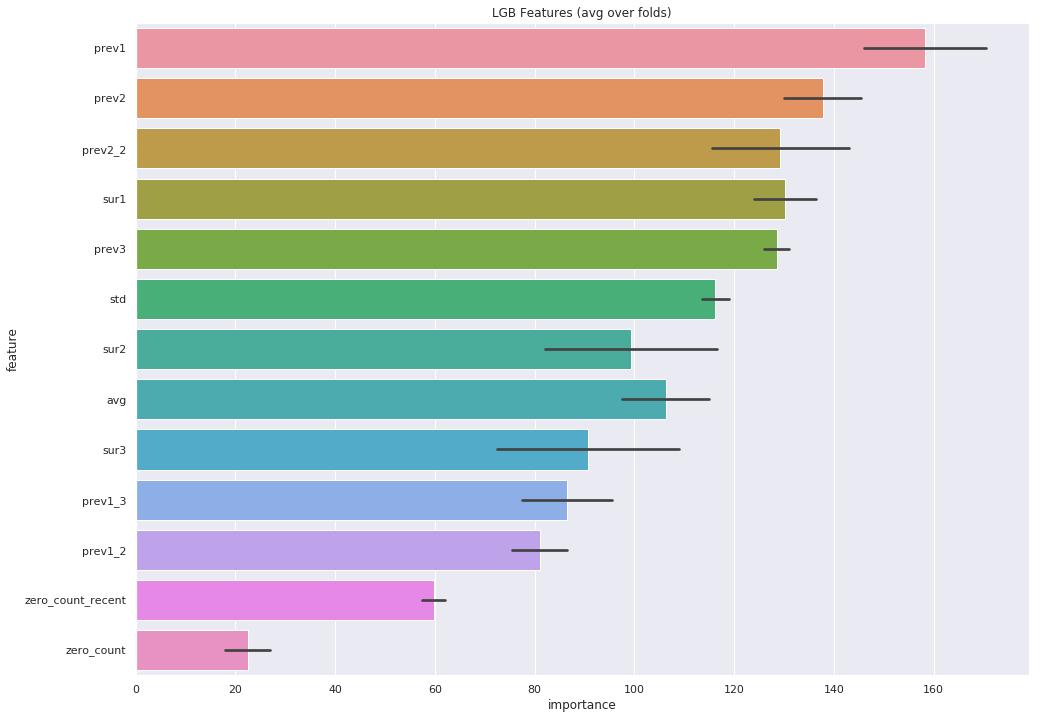

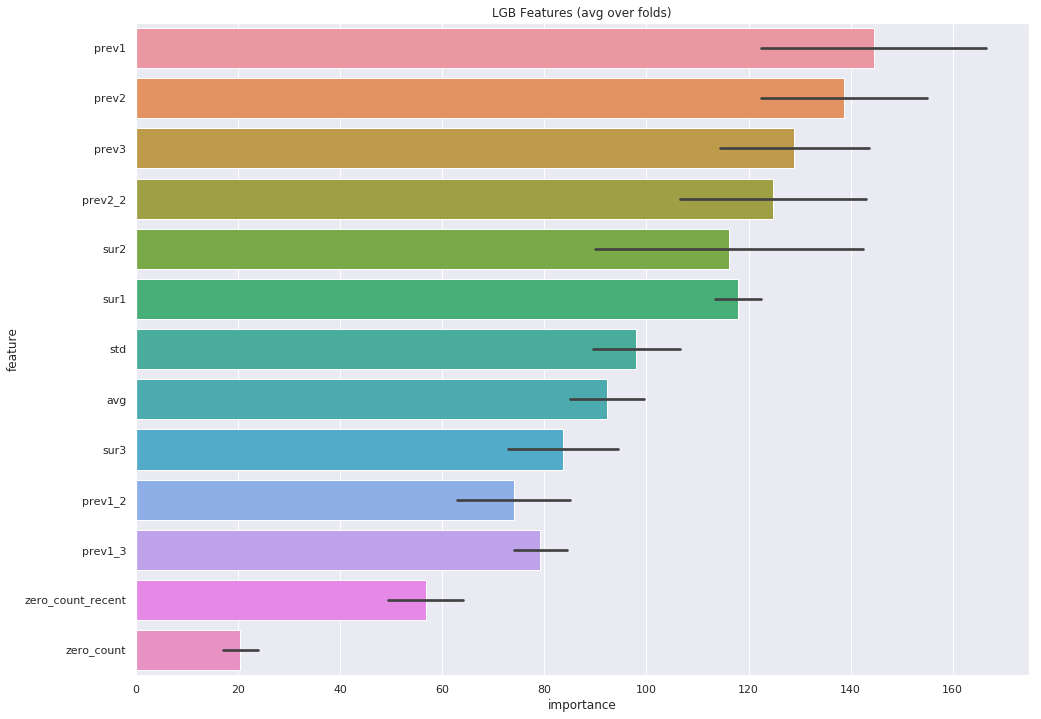

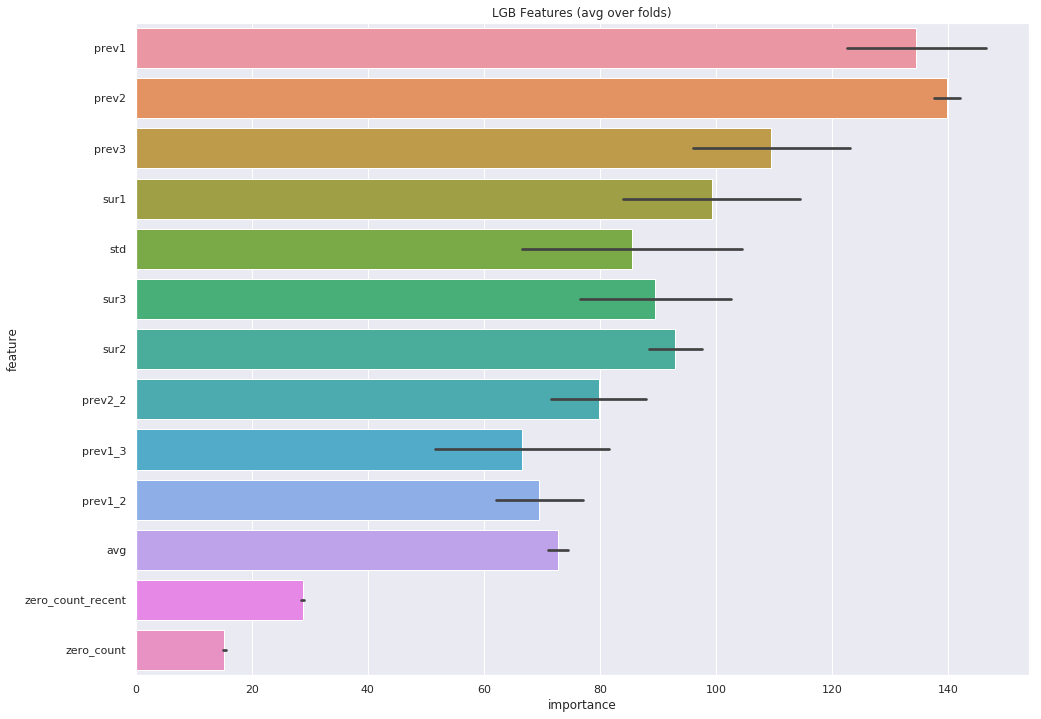

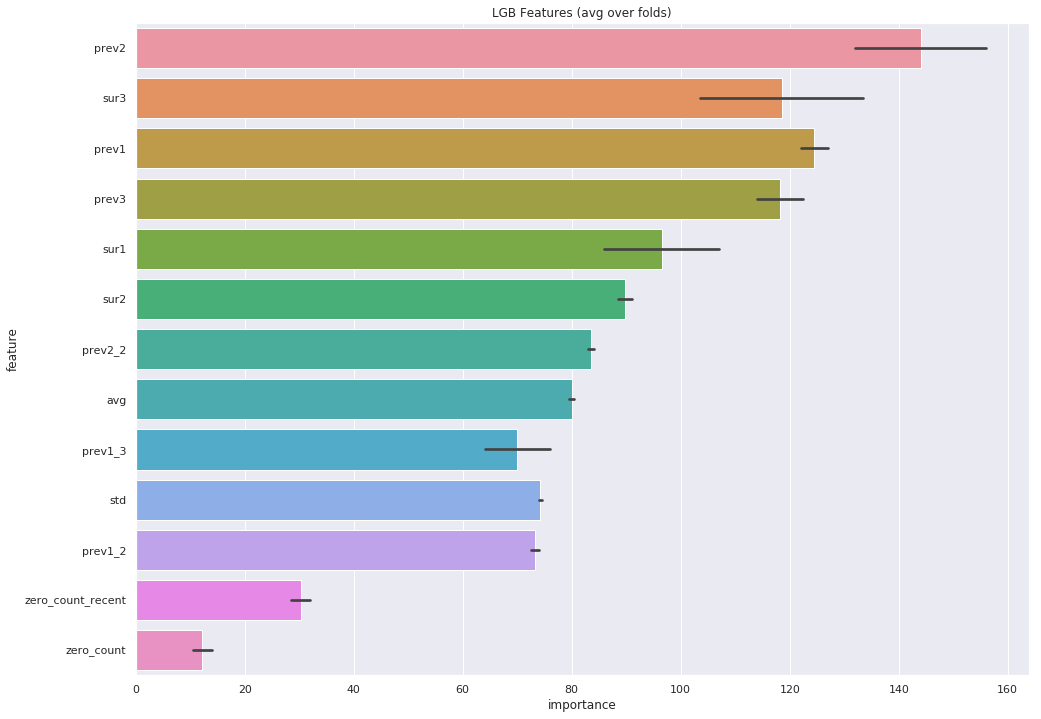

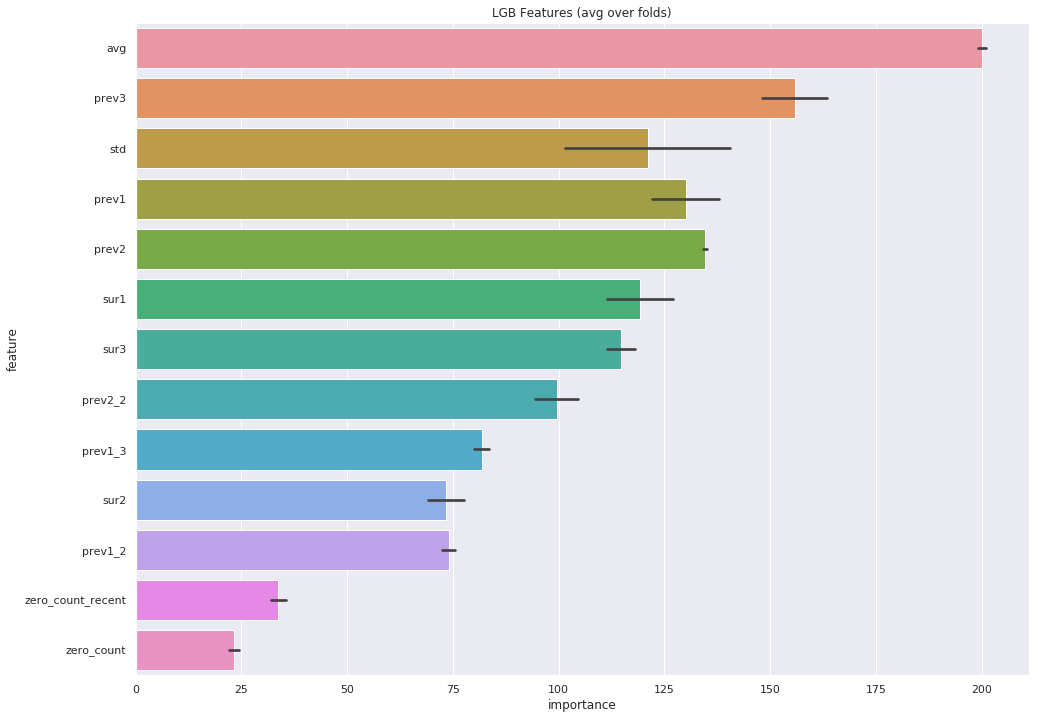

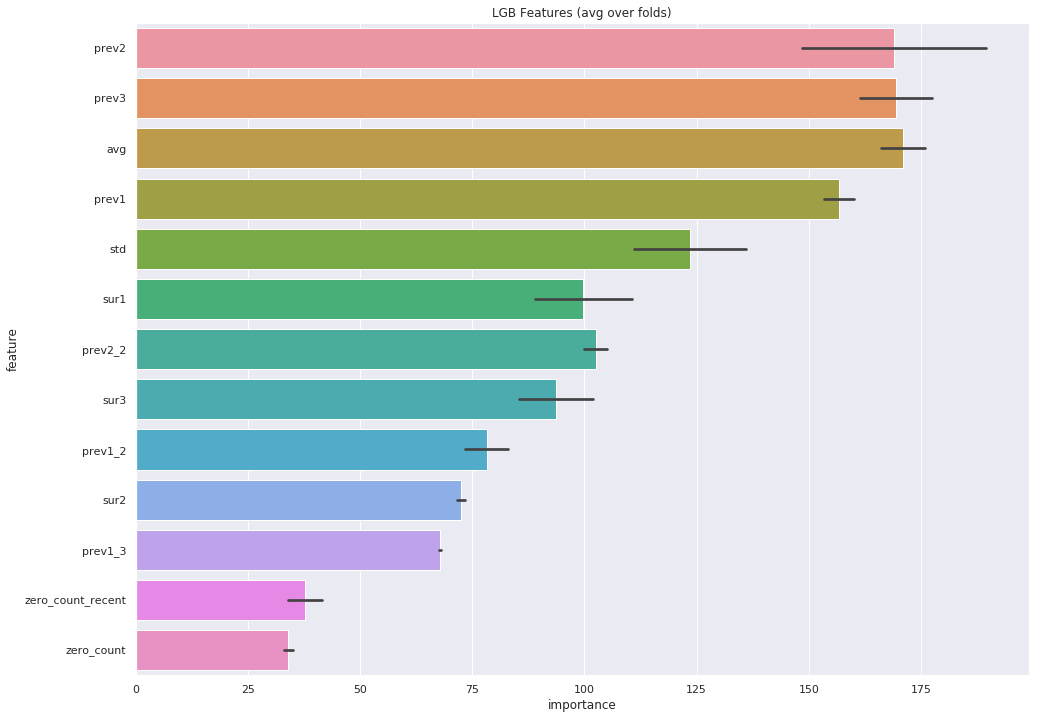

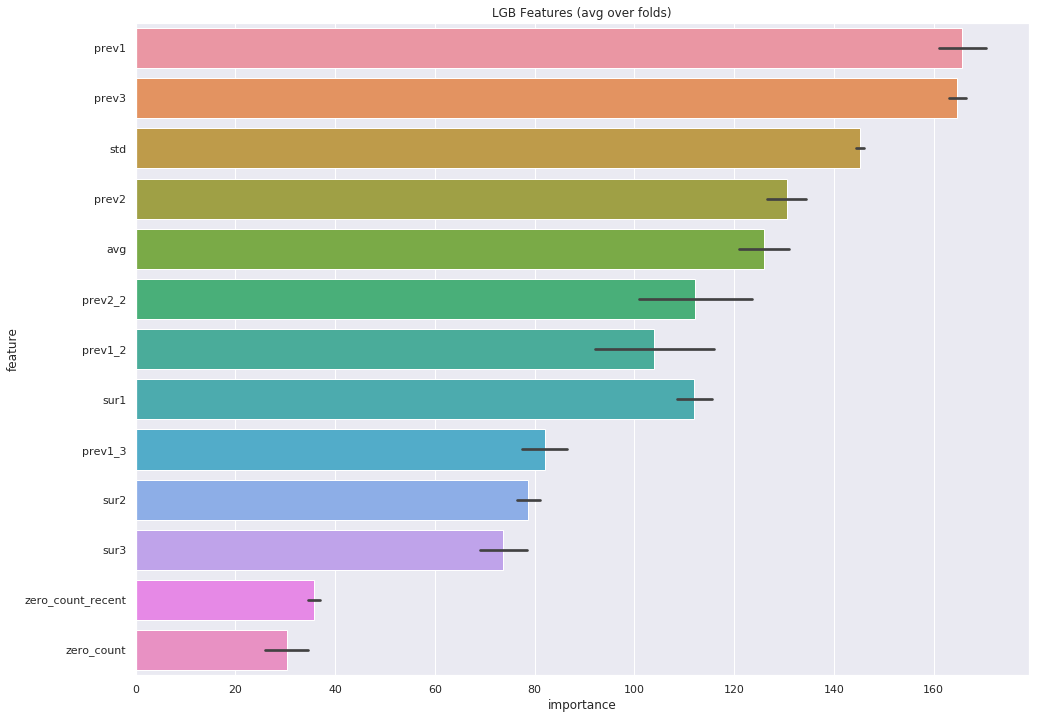

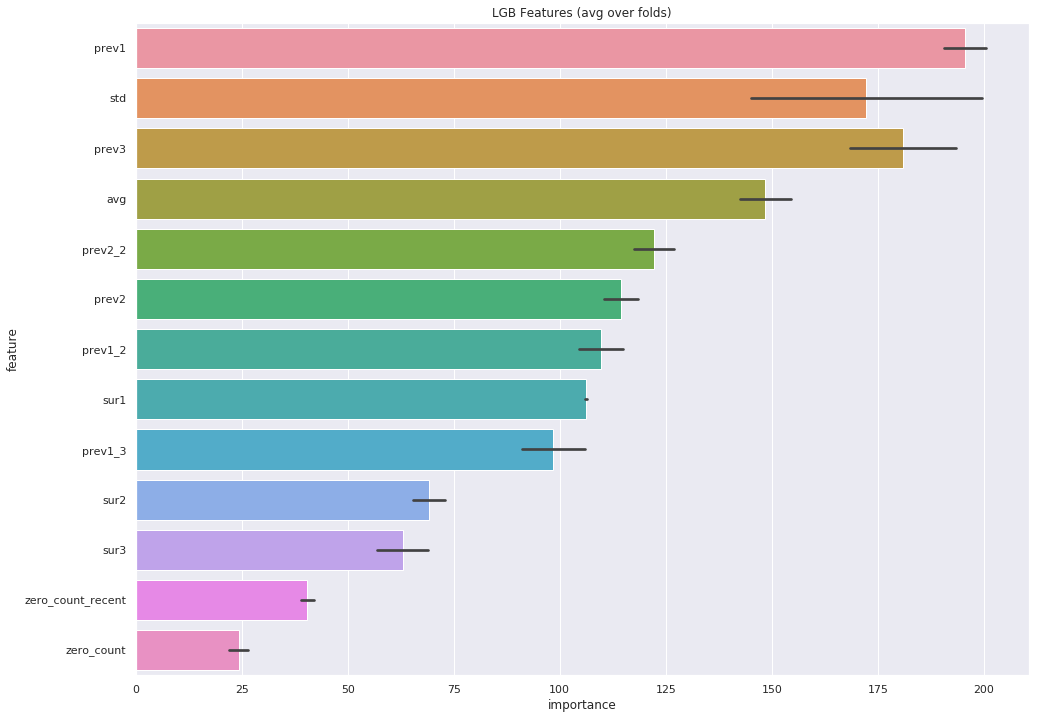

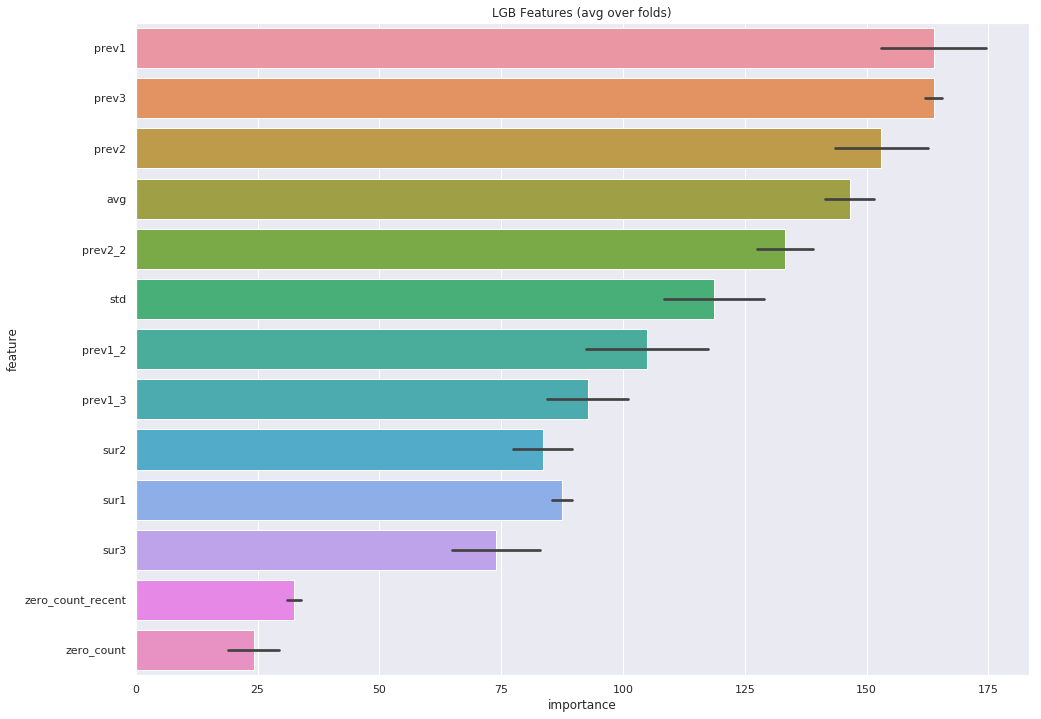

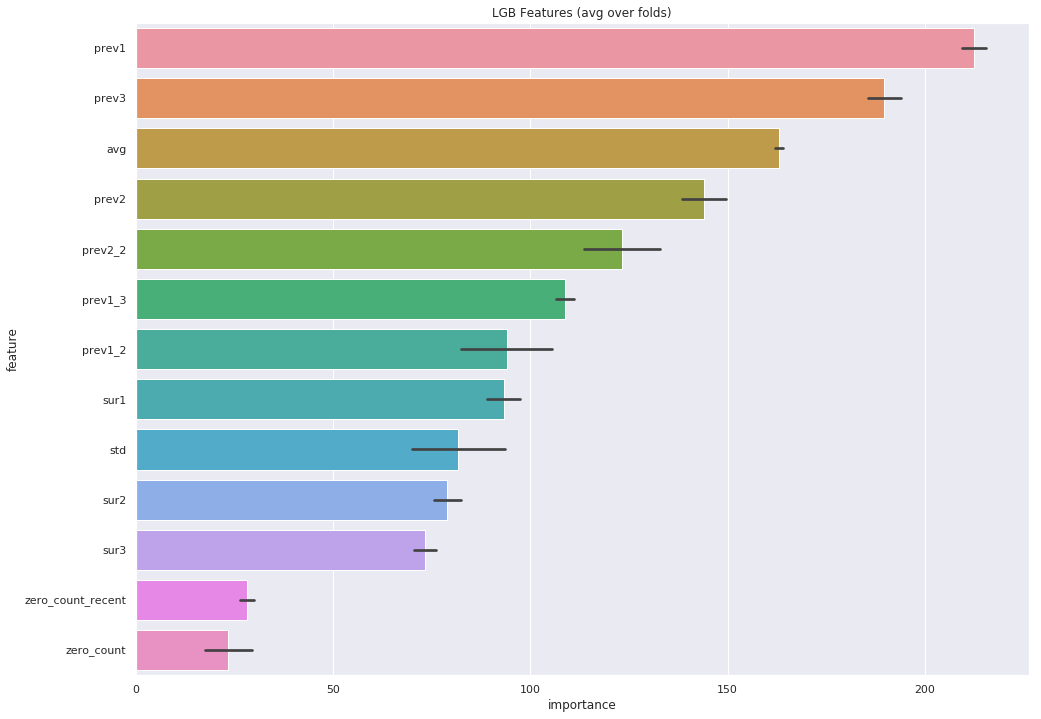

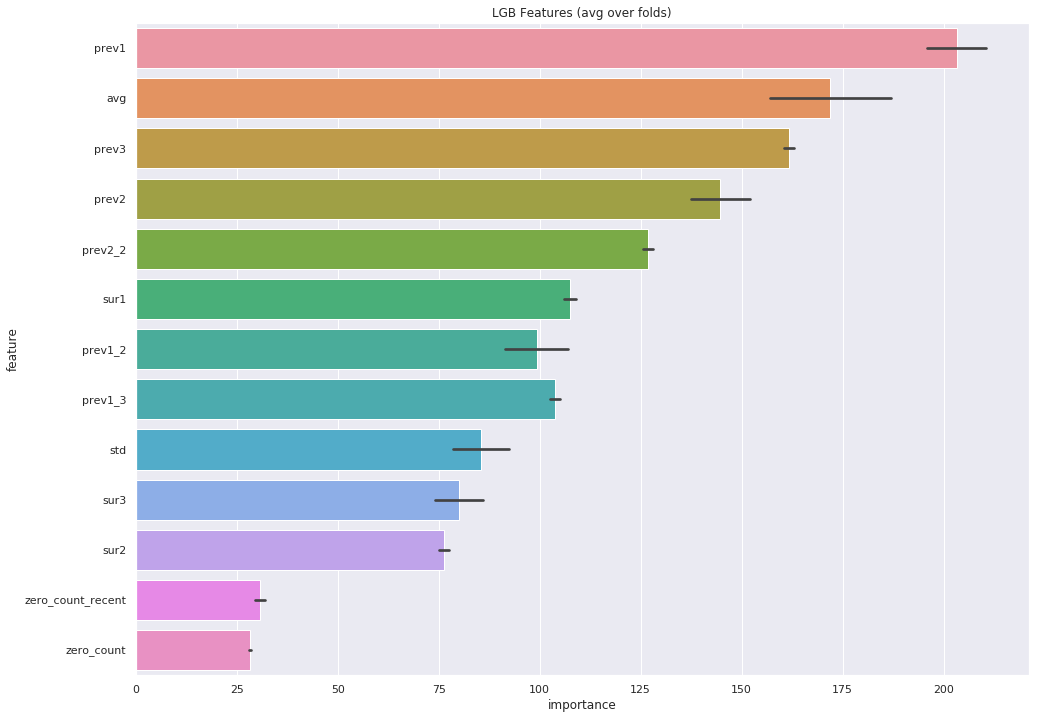

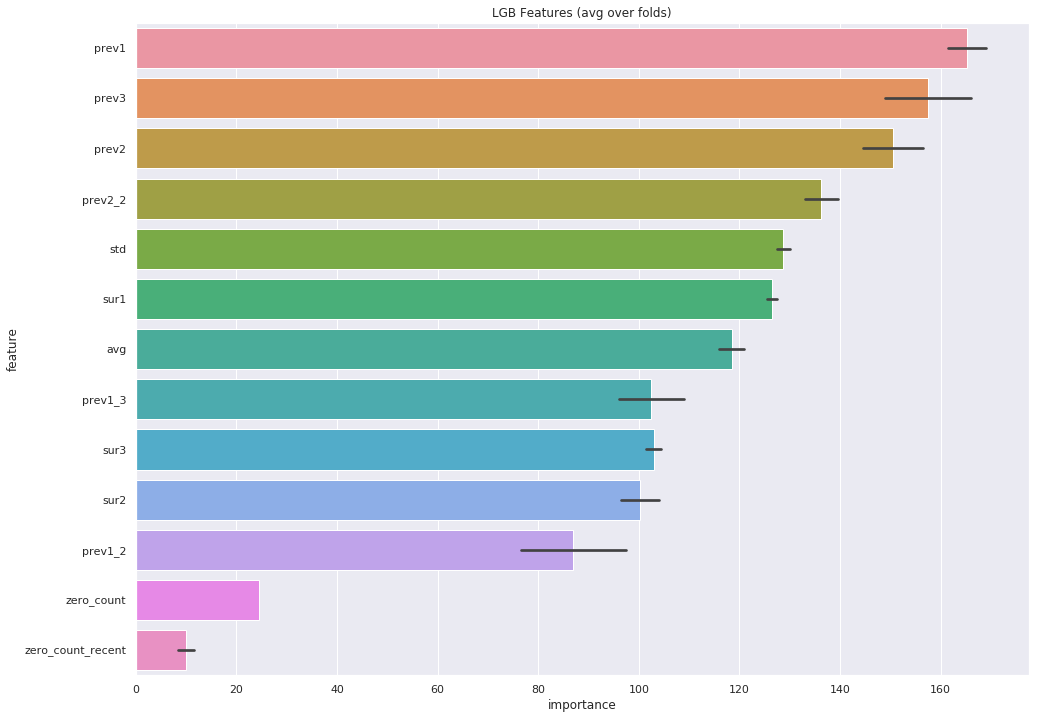

In [774]:
folds = KFold(n_splits=2, shuffle=True, random_state=7)
score_list = []
for idx, month in tqdm(enumerate(list(sample_submission.columns[1:]))): 
    
    print("month:", month)
    all_cols = list(train.columns)
    
    train_df = fe_old(idx, train)
    test_df = fe_old(idx, test, True)
    
    if TRAINING: 
        cols = [c for c in train_df.columns if c not in ['target']]
        X = train_df[cols]
        y = train_df['target']
    
    X_test = test_df[cols]
    
    result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, model_type=MODEL_TYPE, eval_metric='rmse', plot_feature_importance=True,
                                                          early_stopping_rounds=150)
    score_list.append(np.mean(result_dict_lgb['scores']))
    sample_submission[month] = result_dict_lgb['prediction']

In [775]:
score = round(np.mean(score_list),5)
score

21.03265

In [748]:
score = round(np.mean(score_list),5)
score

21.5508

In [741]:
score = round(np.mean(score_list),5)
score

21.5508

In [205]:
sample_submission.to_csv('../code/submission'+'_'+str(score).replace('.', '_')+'.csv', index=False)
pd.read_csv('../code/'+'submission'+'_'+str(score).replace('.', '_')+'.csv')

,id,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05
0,78587,20.489315,16.816352,16.209278,21.320565,21.009815,24.624274,41.649352,60.265954,57.556045,45.315669,27.907567,19.870688
1,78588,23.415072,17.417440,20.337069,17.310516,26.281139,29.318293,45.425640,72.887768,62.841577,42.915695,31.789427,28.611428
2,78589,14.895435,12.297115,8.840572,12.070084,15.232550,20.097663,28.953902,60.098552,55.494560,41.677249,24.665372,14.918129
3,78590,17.917696,12.594719,12.657004,22.033857,19.525876,21.803798,36.999307,57.111049,49.479058,34.517996,24.633622,19.711072
4,78591,19.725956,17.043180,12.758868,17.504538,20.345945,23.225957,37.905492,65.934697,59.436986,46.362133,25.847666,18.695458
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,88582,25.321331,21.526776,20.850858,15.400407,32.232150,33.332342,51.556545,120.634433,68.164409,73.408846,37.094230,25.560589
9996,88583,24.961735,19.491847,13.879740,24.768898,21.632846,34.308296,73.221302,126.946646,123.009589,103.466364,35.165631,25.183069
9997,88584,6.514598,5.333879,4.681425,5.374016,7.865804,9.999364,15.540669,31.346159,30.377206,21.175236,13.480569,7.335804
9998,88585,15.956397,13.001499,11.940334,13.499312,17.350487,23.061260,28.208371,59.924095,52.507703,35.378926,25.668027,19.193082


In [176]:
X_test

,prev1,prev1_2,prev1_3,prev2,prev2_2,prev3,sur1,sur2,sur3,avg,std,zero_count,zero_count_recent
0,15.80,23.71,74.10,19.76,39.53,14.83,19.755,37.870000,47.4225,42.320833,31.272425,0,0
1,25.69,51.38,81.02,14.82,76.10,36.60,38.535,52.696667,58.7900,39.605000,30.596408,0,0
2,12.84,14.82,38.53,10.87,14.82,9.89,13.830,22.063333,31.6150,35.569167,31.579668,0,0
3,10.86,34.58,63.23,20.75,25.69,12.86,22.720,36.223333,48.4100,31.287500,24.172970,0,0
4,14.82,19.76,61.26,16.80,19.76,16.81,17.290,31.946667,42.4850,41.005000,31.013192,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24.70,33.59,78.05,21.74,39.53,13.85,29.145,45.446667,67.1850,64.637500,61.525846,0,0
9996,12.84,29.64,83.00,19.76,49.42,13.85,21.240,41.826667,53.6000,88.025000,93.515252,0,0
9997,4.94,5.92,15.80,4.94,3.95,3.95,5.430,8.886667,7.9000,12.181667,12.543707,0,0
9998,18.77,20.75,19.76,16.80,18.77,16.81,19.760,19.760000,20.2525,27.580833,26.963215,1,0


In [186]:
from sklearn.model_selection import KFold
from tqdm import tqdm

plot_feature_importance = True
n_splits = 2
model_type = 'lgb'

columns = list(train_df.columns)
columns.remove('target')

folds = KFold(n_splits=n_splits, shuffle=True, random_state=123)
feature_importance = pd.DataFrame()
score_list = []
for idx, month in tqdm(enumerate(list(sample_submission.columns[1:]))):
    sub_preds = np.zeros(test.shape[0])


    
    if TRAINING: 
        cols = [c for c in train_df.columns if c not in ['target']]
        X = train_df[cols]
        y = train_df['target']
    
    
    # 0값이 많은 곳 없애기
    train_df = train_df[train_df['zero_count_recent']<=1]
    train_df = train_df[train_df['zero_count']<=3]
    train_df = train_df.reset_index(drop=True)

    
    

    
    score = 0
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_df)):
        x_train = train_df.loc[trn_idx]
        y_train = train_df['target'][trn_idx]
        x_val = train_df.loc[val_idx]
        y_val = train_df['target'][val_idx]
        model, result, val_score = run_lgb(x_train, y_train, x_val, y_val, test_df)
        sub_preds += result['demand'] / folds.n_splits
        score += val_score/n_splits
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = n_fold + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

        
        
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance


    print("total score:", score)
    score_list.append(score)
    sample_submission[month] = sub_preds
    
print("validation score:", np.mean(score))





0it [00:00, ?it/s]

processing..  2018-06
2017-06
Training until validation scores don't improve for 400 rounds
[100]	training's rmse: 12.8052	valid_1's rmse: 13.0295
[200]	training's rmse: 11.4713	valid_1's rmse: 11.7884
[300]	training's rmse: 10.823	valid_1's rmse: 11.2167
[400]	training's rmse: 10.4932	valid_1's rmse: 10.9469
[500]	training's rmse: 10.3117	valid_1's rmse: 10.8192
[600]	training's rmse: 10.1961	valid_1's rmse: 10.75
[700]	training's rmse: 10.1134	valid_1's rmse: 10.7076
[800]	training's rmse: 10.0547	valid_1's rmse: 10.6844
[900]	training's rmse: 10.0016	valid_1's rmse: 10.6679
[1000]	training's rmse: 9.95558	valid_1's rmse: 10.6557
[1100]	training's rmse: 9.91705	valid_1's rmse: 10.6485
[1200]	training's rmse: 9.87775	valid_1's rmse: 10.6411
[1300]	training's rmse: 9.84134	valid_1's rmse: 10.6364
[1400]	training's rmse: 9.80708	valid_1's rmse: 10.6326
[1500]	training's rmse: 9.77526	valid_1's rmse: 10.6292
[1600]	training's rmse: 9.74293	valid_1's rmse: 10.6262
[1700]	training's rmse: 

AttributeError: 'Booster' object has no attribute 'feature_importances_'

In [ ]:
from sklearn.model_selection import KFold

folds = KFold(n_splits=5, shuffle=True, random_state=123)
score_list = []
for idx, month in enumerate(list(sample_submission.columns[1:])):
    sub_preds = np.zeros(test.shape[0])
    train_df = fe(36+idx, train)
    test_df = fe(36+idx, test, True)
    
    # 0값이 많은 곳 없애기
    train_df = train_df[train_df['zero_count_recent']<=1]
    train_df = train_df[train_df['zero_count']<=3]
    train_df = train_df.reset_index(drop=True)
    
    
    score = 0
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_df)):
        x_train = train_df.loc[trn_idx]
        y_train = train_df['target'][trn_idx]
        x_val = train_df.loc[val_idx]
        y_val = train_df['target'][val_idx]
        result, val_score = run_lgb(x_train, y_train, x_val, y_val, test_df)
        sub_preds += result['demand'] / folds.n_splits
        score += val_score/5

    print("total score:", score)
    score_list.append(score)
    sample_submission[month] = sub_preds
    
print("validation score:", np.mean(score))

In [ ]:
# old version 2

In [759]:
def run_lgb(x_train, y_train, x_val, y_val, test_df):
    
    features = list(x_train.columns)[:-1]
    #gc.collect()

    params = {
        'boosting_type': 'gbdt',
        'objective': 'poisson',
        'metric': 'rmse',
        'learning_rate': 0.01,
        'num_leaves':255,
        'max_depth': 8,  
        'min_child_samples': 100,  
        'max_bin': 100,  
        'subsample': 0.7,  
        'subsample_freq': 1,  
        'colsample_bytree': 0.7,  
        'min_child_weight': 0,  
        'subsample_for_bin': 200000,  
        'min_split_gain': 0,  
        'reg_alpha': 0,  
        'reg_lambda': 0,  
       # 'nthread': 8,
        'verbose': 0,
        'scale_pos_weight':99 
        }

    
#     params = {
# #         'boosting_type': 'gbdt',
#         'metric': 'rmse',
#         'objective': 'poisson',
#         'n_jobs': -1,
#         'seed': 20,
#         'learning_rate': 0.1,
#         'alpha': 0.1,
#         'lambda': 0.1,
#         'bagging_fraction': 0.66,
#         'bagging_freq': 2, 
#         'colsample_bytree': 0.77}

    train_set = lgb.Dataset(x_train[features], y_train)
    val_set = lgb.Dataset(x_val[features], y_val)
    
    del x_train, y_train
    
    model = lgb.train(params, train_set, num_boost_round = 5000, early_stopping_rounds = 400, valid_sets = [train_set, val_set], verbose_eval = 100)
    joblib.dump(model, 'lgbm_0.sav')
    
    val_pred = model.predict(x_val[features], num_iteration=model.best_iteration)
    val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
    print(f'Our val rmse score is {val_score}')
    y_pred = model.predict(test_df[features], num_iteration=model.best_iteration)
    test_df['demand'] = y_pred
    return test_df, val_score
    
score_list = []
    
for idx, month in enumerate(list(sample_submission.columns[1:])):

    print("month:", month)
    train_df = fe_old(idx, train)
    test_df = fe_old(idx, test, True)
    
    score = 0
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_df)):
        x_train = train_df.loc[trn_idx]
        y_train = train_df['target'][trn_idx]
        x_val = train_df.loc[val_idx]
        y_val = train_df['target'][val_idx]
        result, val_score = run_lgb(x_train, y_train, x_val, y_val, test_df)
        sub_preds += result['demand'] / folds.n_splits
        score += val_score/folds.n_splits
    score_list.append(score)

month: 2018-06
month: 2018-06
2017-06
2017-05
2017-04
2016-06
2016-05
2015-06
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05']
지난 2년: ['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017

Training until validation scores don't improve for 400 rounds
[100]	training's rmse: 8.04888	valid_1's rmse: 7.94203
[200]	training's rmse: 7.38537	valid_1's rmse: 7.33724
[300]	training's rmse: 7.08624	valid_1's rmse: 7.08826
[400]	training's rmse: 6.9438	valid_1's rmse: 6.98636
[500]	training's rmse: 6.86783	valid_1's rmse: 6.94509
[600]	training's rmse: 6.82041	valid_1's rmse: 6.92775
[700]	training's rmse: 6.78611	valid_1's rmse: 6.92055
[800]	training's rmse: 6.76035	valid_1's rmse: 6.91733
[900]	training's rmse: 6.73913	valid_1's rmse: 6.91624
[1000]	training's rmse: 6.72034	valid_1's rmse: 6.916
[1100]	training's rmse: 6.70115	valid_1's rmse: 6.91626
[1200]	training's rmse: 6.68478	valid_1's rmse: 6.91642
[1300]	training's rmse: 6.66735	valid_1's rmse: 6.91652
[1400]	training's rmse: 6.65218	valid_1's rmse: 6.91713
Early stopping, best iteration is:
[1029]	training's rmse: 6.7145	valid_1's rmse: 6.91579
Our val rmse score is 6.915793026834709
Training until validation scores don

[200]	training's rmse: 11.1617	valid_1's rmse: 11.2205
[300]	training's rmse: 10.6725	valid_1's rmse: 10.8127
[400]	training's rmse: 10.4452	valid_1's rmse: 10.6485
[500]	training's rmse: 10.3287	valid_1's rmse: 10.5835
[600]	training's rmse: 10.258	valid_1's rmse: 10.5573
[700]	training's rmse: 10.211	valid_1's rmse: 10.5463
[800]	training's rmse: 10.1749	valid_1's rmse: 10.5432
[900]	training's rmse: 10.1449	valid_1's rmse: 10.5425
[1000]	training's rmse: 10.1191	valid_1's rmse: 10.5432
[1100]	training's rmse: 10.0966	valid_1's rmse: 10.5457
[1200]	training's rmse: 10.0743	valid_1's rmse: 10.5484
Early stopping, best iteration is:
[882]	training's rmse: 10.1501	valid_1's rmse: 10.5423
Our val rmse score is 10.542279001924328
month: 2018-11
month: 2018-11
2017-11
2017-10
2017-09
2016-11
2016-10
2015-11
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10

Training until validation scores don't improve for 400 rounds
[100]	training's rmse: 52.7857	valid_1's rmse: 52.9064
[200]	training's rmse: 46.3994	valid_1's rmse: 46.6468
[300]	training's rmse: 43.611	valid_1's rmse: 44.0167
[400]	training's rmse: 42.3744	valid_1's rmse: 42.9463
[500]	training's rmse: 41.7943	valid_1's rmse: 42.5135
[600]	training's rmse: 41.4851	valid_1's rmse: 42.3406
[700]	training's rmse: 41.2929	valid_1's rmse: 42.2647
[800]	training's rmse: 41.1619	valid_1's rmse: 42.2352
[900]	training's rmse: 41.0602	valid_1's rmse: 42.2236
[1000]	training's rmse: 40.973	valid_1's rmse: 42.2206
[1100]	training's rmse: 40.8896	valid_1's rmse: 42.2208
[1200]	training's rmse: 40.8164	valid_1's rmse: 42.2238
[1300]	training's rmse: 40.742	valid_1's rmse: 42.2286
[1400]	training's rmse: 40.6705	valid_1's rmse: 42.2325
Early stopping, best iteration is:
[1045]	training's rmse: 40.9375	valid_1's rmse: 42.2185
Our val rmse score is 42.218494660778106
Training until validation scores d

Our val rmse score is 33.59176091808798
Training until validation scores don't improve for 400 rounds
[100]	training's rmse: 40.4649	valid_1's rmse: 40.6548
[200]	training's rmse: 35.9098	valid_1's rmse: 36.4354
[300]	training's rmse: 33.9184	valid_1's rmse: 34.7239
[400]	training's rmse: 33.0291	valid_1's rmse: 34.0475
[500]	training's rmse: 32.5973	valid_1's rmse: 33.7868
[600]	training's rmse: 32.3538	valid_1's rmse: 33.6831
[700]	training's rmse: 32.2005	valid_1's rmse: 33.637
[800]	training's rmse: 32.0903	valid_1's rmse: 33.6187
[900]	training's rmse: 32.0049	valid_1's rmse: 33.6074
[1000]	training's rmse: 31.9316	valid_1's rmse: 33.6035
[1100]	training's rmse: 31.8653	valid_1's rmse: 33.6023
[1200]	training's rmse: 31.805	valid_1's rmse: 33.6052
[1300]	training's rmse: 31.7492	valid_1's rmse: 33.6036
[1400]	training's rmse: 31.6935	valid_1's rmse: 33.6047
Early stopping, best iteration is:
[1095]	training's rmse: 31.8685	valid_1's rmse: 33.6018
Our val rmse score is 33.601787063

In [761]:
np.mean(score_list)

21.4360167708622

In [ ]:


# jun = train.columns[[i*12-6 for i in range(1, 5)]]
# jul = train.columns[[i*12-5 for i in range(1, 5)]]
# aug = train.columns[[i*12-4 for i in range(1, 5)]]
# sep = train.columns[[i*12-3 for i in range(1, 5)]]
# occ = train.columns[[i*12-2 for i in range(1, 5)]]
# nov = train.columns[[i*12-1 for i in range(1, 5)]]
# dec = train.columns[[i*12 for i in range(4)]]
# jan = train.columns[[1+i*12 for i in range(4)]]
# feb = train.columns[[2+i*12 for i in range(4)]]
# mar = train.columns[[3+i*12 for i in range(4)]]
# apr = train.columns[[4+i*12 for i in range(4)]]
# may = train.columns[[5+i*12 for i in range(4)]]

# df_jun = train[jun].copy()
# df_jul = train[jul].copy()
# df_aug = train[aug].copy()
# df_sep = train[sep].copy()
# df_occ = train[occ].copy()
# df_nov = train[nov].copy()
# df_dec = train[dec].copy()
# df_jan = train[jan].copy()
# df_feb = train[feb].copy()
# df_mar = train[mar].copy()
# df_apr = train[apr].copy()
# df_may = train[may].copy()